In [98]:
import os
import warnings
import yfinance as yf
import numpy as np
import pandas as pd
import talib
import matplotlib
matplotlib.use('Agg')  # 必须添加：防止在后台运行时尝试打开窗口导致报错
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ============================================================
# STEP 0: DATA FETCHING & PREPROCESSING
# ============================================================
# ===================== 手动输入股票代码 =====================
# 1. 基础输入（带默认值，回车直接用恒生指数）
ticker_symbol = input("请输入要回测的股票/指数代码（默认：^HSI 恒生指数）：").strip()
# 2. 空输入时用默认值
if not ticker_symbol:
    ticker_symbol = "^HSI"
    print(f"未输入代码，使用默认值：{ticker_symbol}（恒生指数）")

# 3. 输入校验（检查yfinance是否能获取该代码的数据）
print(f"\n正在验证代码 {ticker_symbol} 的有效性...")
temp_ticker = yf.Ticker(ticker_symbol)
temp_df = temp_ticker.history(period="1d")  # 仅获取1天数据验证

if temp_df.empty:
    # 校验失败，提示并强制使用默认值
    print(f"⚠️ 输入的代码 {ticker_symbol} 无效（无数据），自动切换为默认值 ^HSI")
    ticker_symbol = "^HSI"
    ticker = yf.Ticker(ticker_symbol)
else:
    # 校验成功，创建Ticker对象
    print(f"✅ 代码 {ticker_symbol} 验证通过！")
    ticker = yf.Ticker(ticker_symbol)

#print("Fetching HSI data...")
#ticker = yf.Ticker("^HSI")
#end_date = datetime.now()
end_date = datetime.now()+timedelta(days=1)

start_date = end_date - timedelta(days=20*365)
df = ticker.history(start=start_date, end=end_date)
print(f"最新日期: {df.index[-1].strftime('%Y-%m-%d')}")

# 1. 波动率指数 (VHSI)
print("Fetching HSIL (Volatility Index) data...")
vix_ticker = yf.Ticker("^HSIL")
vix_df = vix_ticker.history(start=start_date, end=end_date)

if vix_df.empty:
    print("⚠️ Warning: ^HSIL data is missing. Using default volatility fallback.")
    df['VIX_Close'] = 20.0 # 兜底方案：基于历史长期中位数填充
else:
    # 外部数据强制滞后一期，确保仅利用截止昨日的信息预测今日
    df = df.join(vix_df['Close'].rename('VIX_Close').shift(1), how='left')
    df['VIX_Close'] = df['VIX_Close'].ffill(limit=5)
    vix_fallback = df['VIX_Close'].rolling(20, min_periods=1).mean()
    df['VIX_Close'] = df['VIX_Close'].fillna(vix_fallback).fillna(20.0)

# 基础清洗
df = df.dropna(subset=['Close'])
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
last_3_days = df.index[-3:]
df = df[(df['Volume'] > 0) | (df.index.isin(last_3_days))].copy()
df.index = pd.to_datetime(df.index).tz_localize(None)

# 2. 获取外部资产数据
print("Fetching External Assets...")
tickers_dict = {
    'SPX_Close': '^GSPC',
    'SSE_Close': '000001.SS',
    'USDCNH_Close': 'CNH=F',
    'US10Y_Close': '^TNX',
    'USDHKD_Close': 'HKD=X',
    'DXY_Close': 'DX-Y.NYB',
    'GOLD_Close': 'GC=F',
}

for col_name, ticker_symbol in tickers_dict.items():
    try:
        ext_df = yf.Ticker(ticker_symbol).history(start=start_date, end=end_date)
        ext_df.index = pd.to_datetime(ext_df.index).tz_localize(None)
        if ext_df.empty:
            print(f"    ⚠️ Warning: {col_name} data is empty/sparse.")
            df[col_name] = np.nan
        else:
            # 同样强制滞后一期，防止利用跨市场时区差异引入未来数据
            df = df.join(ext_df['Close'].rename(col_name).shift(1), how='left')
    except Exception as e:
        print(f"    ❌ Error fetching {ticker_symbol}: {e}")
        df[col_name] = np.nan

# 3. 填充外部数据
# 严禁使用 bfill，防止未来数据回填导致回测结果虚高
df[list(tickers_dict.keys())] = df[list(tickers_dict.keys())].ffill()

# 4. 计算外部资产收益率
# 显式指定 fill_method=None 以避免 Pandas 2.0+ 版本警告
df['SPX_Ret'] = df['SPX_Close'].pct_change(fill_method=None).fillna(0)
df['SSE_Ret'] = df['SSE_Close'].pct_change(fill_method=None).fillna(0)

print("External data fetched and merged.")
print(f"Data shape: {df.shape}")


# ============================================================
# STEP 1: DEFINE TRADING PATTERNS (CORRECTED LOGIC)
# ============================================================
def detect_trading_patterns(df):
    df = df.copy()
    patterns = pd.DataFrame(index=df.index)

    # 0. 准备基础数据 (Float64)
    open_p = df['Open'].values.astype(np.float64)
    high_p = df['High'].values.astype(np.float64)
    low_p = df['Low'].values.astype(np.float64)
    close_p = df['Close'].values.astype(np.float64)
    volume_p = df['Volume'].values.astype(np.float64)

    # 1. 基础收益率
    df['Returns'] = df['Close'].pct_change(fill_method=None).fillna(0)
    patterns['Returns'] = df['Returns']
    # Log Return 用于计算
    patterns['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1)).fillna(0)

    # 2. 波动率基准 (ATR)
    atr_20 = talib.ATR(high_p, low_p, close_p, timeperiod=20)
    atr_20_s = pd.Series(atr_20, index=df.index)
    patterns['Volatility_Ratio'] = atr_20_s / (atr_20_s.rolling(20, min_periods=20).mean().shift(1) + 1e-10)

    # 3. 跳空缺口 (Gaps)
    prev_close = df['Close'].shift(1)
    prev_atr = atr_20_s.shift(1)
    gap_raw = (df['Open'] - prev_close) / prev_close
    gap_threshold = (prev_atr / prev_close * 0.5).fillna(1.0)
    patterns['Gap_Up'] = (gap_raw > 0).astype(float) * gap_raw * (gap_raw > gap_threshold).astype(float)
    patterns['Gap_Down'] = (gap_raw < 0).astype(float) * abs(gap_raw) * (abs(gap_raw) > gap_threshold).astype(float)

    # =======================================================
    #  4. 成交量因子 (Volume Factors - Dual Horizon & Regimes)
    # =======================================================

    # --- A. 基础计算：双时间窗口基准 ---
    # 20日均量：捕捉中期趋势 (机构视角)
    vol_ma_20 = df['Volume'].rolling(window=20, min_periods=5).mean()
    # 5日均量：捕捉短期突变 (游资/事件视角)
    vol_ma_5 = df['Volume'].rolling(window=5, min_periods=3).mean()

    # 相对量能 (Relative Volume) - 连续型指标
    # 使用 20 日作为主基准，描述整体热度
    patterns['Vol_Rel_20'] = (df['Volume'] / (vol_ma_20 + 1e-10)).replace([np.inf, -np.inf], 0).fillna(0)
    # 使用 5 日作为敏捷基准，描述短期爆发力
    patterns['Vol_Rel_5'] = (df['Volume'] / (vol_ma_5 + 1e-10)).replace([np.inf, -np.inf], 0).fillna(0)

    # --- B. 状态信号：自适应阈值 ---
    # 极度放量 (Relative > 2.0)
    patterns['Vol_Surge'] = (patterns['Vol_Rel_20'] > 2.0).astype(float)
    # 明显缩量 (Relative < 0.6)
    patterns['Vol_Dry_Up'] = (patterns['Vol_Rel_20'] < 0.6).astype(float)

    # --- C. 量价逻辑拆分 ---
    # 上涨放量 (Bullish Force): 价格涨 且 量能大于 20日均线 1.2倍
    patterns['Vol_Price_Up_Confirm'] = (
        (patterns['Log_Ret'] > 0) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Vol_Rel_20'] # 保留强度作为权重

    # 下跌放量 (Panic Selling): 价格跌 且 量能大于 20日均线 1.2倍
    patterns['Vol_Price_Down_Panic'] = (
        (patterns['Log_Ret'] < 0) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Vol_Rel_20'] # 保留强度作为权重

    # 缩量回调 (Healthy Pullback): 价格跌 但 量能小于 5日均线 (短期缩量)
    patterns['Vol_Pullback_Low'] = (
        (patterns['Log_Ret'] < 0) & (patterns['Vol_Rel_5'] < 0.8)
    ).astype(float)

    # --- D. 量价偏差与连续性 ---
    # 量能偏差 (连续变量): 正值代表放量，负值代表缩量
    patterns['Vol_Bias_20'] = (patterns['Vol_Rel_20'] - 1.0)

    # 量价趋势一致性 (3日窗口)
    # 逻辑：价格变化方向 == 成交量变化方向 (涨且增量，或跌且缩量)
    vol_diff = df['Volume'].diff()
    price_diff = df['Close'].diff()

    is_up_vol = (price_diff > 0) & (vol_diff > 0)
    is_down_dry = (price_diff < 0) & (vol_diff < 0)

    # 3天内符合“顺势量价”的天数 (0, 1, 2, 3)
    patterns['Vol_Trend_Consistency'] = (is_up_vol | is_down_dry).rolling(3).sum().fillna(0)

    # 兼容性别名 (供后续旧代码逻辑引用)
    patterns['Vol_Rel'] = patterns['Vol_Rel_20']
    patterns['High_Volume'] = patterns['Vol_Surge']

    # =======================================================

    # 5. 反转形态
    # 更新：使用新的 Vol_Rel_20 替代
    avg_vol_20 = vol_ma_20 # 复用变量
    patterns['Gap_Up_Reversal'] = (
        (patterns['Gap_Up'] > 0.005) & (df['Close'] < df['Open']) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Gap_Up']

    patterns['Gap_Down_Reversal'] = (
        (patterns['Gap_Down'] > 0.005) & (df['Close'] > df['Open']) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Gap_Down']

    # 6. 趋势连续性
    patterns['Trend_2Day'] = df['Log_Ret'].rolling(2).sum().fillna(0)
    t2_sign = np.sign(patterns['Trend_2Day'])
    patterns['Trend_Consistency'] = ((t2_sign == t2_sign.shift(1)) & (t2_sign == t2_sign.shift(2))).astype(float).fillna(0)

    # 7. 回撤反弹
    rolling_max = df['Close'].rolling(20).max().shift(1)
    drawdown = (df['Close'].shift(1) - rolling_max) / (rolling_max + 1e-10)
    drawdown_5pct = drawdown.rolling(10).quantile(0.1).fillna(-0.05)
    patterns['Drawdown_Bounce'] = ((drawdown < drawdown_5pct) & (df['Returns'] > 0.01)).astype(float) * df['Returns']

    # 8. 趋势天数
    patterns['2Day_Uptrend'] = ((df['Returns'] > 0) & (df['Returns'].shift(1) > 0)).astype(float)
    patterns['2Day_Downtrend'] = ((df['Returns'] < 0) & (df['Returns'].shift(1) < 0)).astype(float)
    patterns['3Day_Uptrend'] = ((df['Returns'] > 0) & (df['Returns'].shift(1) > 0) & (df['Returns'].shift(2) > 0)).astype(float)

    # 9. 突破形态
    roll_high = df['High'].rolling(20).max().shift(1)
    roll_low = df['Low'].rolling(20).min().shift(1)
    # 更新：使用 Vol_Rel_20 替代原有的硬编码 Volume
    patterns['Breakout_High'] = ((df['Close'] > roll_high) & (patterns['Vol_Rel_20'] > 1.5)).astype(float) * ((df['Close'] - roll_high) / roll_high)
    patterns['Breakdown_Low'] = ((df['Close'] < roll_low) & (patterns['Vol_Rel_20'] > 1.5)).astype(float) * ((roll_low - df['Close']) / roll_low)
    patterns['Breakout_Confirm'] = ((patterns['Breakout_High'] > 0) & (patterns['Breakout_High'].shift(1) > 0)).astype(float)

    # 10. 波动模式
    daily_range = (df['High'] - df['Low']) / (df['Low'] + 1e-10)
    patterns['High_Volatility'] = (daily_range > 0.02).astype(float) * daily_range
    patterns['Low_Volatility'] = (daily_range < 0.005).astype(float) * (0.005 - daily_range)

    # 12. 动量模式
    ret_5d = df['Close'].pct_change(5, fill_method=None)
    patterns['Strong_Momentum_Up'] = (ret_5d > 0.03).astype(float) * ret_5d / 0.03
    patterns['Strong_Momentum_Down'] = (ret_5d < -0.03).astype(float) * abs(ret_5d) / 0.03

    # 13. 日内形态
    patterns['Inside_Day'] = ((df['High'] < df['High'].shift(1)) & (df['Low'] > df['Low'].shift(1))).astype(float)
    patterns['Outside_Day'] = ((df['High'] > df['High'].shift(1)) & (df['Low'] < df['Low'].shift(1))).astype(float) * daily_range

    # 14. RSI
    rsi = talib.RSI(close_p, timeperiod=14)
    rsi_s = pd.Series(rsi, index=df.index).fillna(50)
    patterns['RSI_Overbought'] = (rsi_s > 70).astype(float) * (rsi_s - 70) / 30
    patterns['RSI_Oversold'] = (rsi_s < 30).astype(float) * (30 - rsi_s) / 30
    patterns['RSI_Near_50'] = ((rsi_s >= 45) & (rsi_s <= 55)).astype(float)
    patterns['RSI_Divergence'] = np.clip((rsi_s - 50) / 50.0, -1, 1)

    # 15. MACD
    macd, signal, hist = talib.MACD(close_p, fastperiod=12, slowperiod=26, signalperiod=9)
    macd_s, signal_s = pd.Series(macd, index=df.index), pd.Series(signal, index=df.index)
    hist_s = pd.Series(hist, index=df.index).fillna(0)
    patterns['MACD_Bullish_Cross'] = ((macd_s > signal_s) & (macd_s.shift(1) <= signal_s.shift(1))).astype(float)
    patterns['MACD_Bearish_Cross'] = ((macd_s < signal_s) & (macd_s.shift(1) >= signal_s.shift(1))).astype(float)

    # 16. 布林带
    bb_mid = df['Close'].rolling(20).mean().shift(1)
    bb_std = df['Close'].rolling(20).std().fillna(0).shift(1)
    bb_upper, bb_lower = bb_mid + 2 * bb_std, bb_mid - 2 * bb_std
    bb_width = (bb_upper - bb_lower) / (bb_mid + 1e-10)

    bb_width_clipped = np.clip(bb_width.shift(1), 0, bb_width.quantile(0.99))
    bb_width_quantile = bb_width_clipped.rolling(60).quantile(0.1).shift(1)

    patterns['BB_Position'] = np.clip((df['Close'] - bb_mid) / (bb_std + 1e-10), -3, 3)
    patterns['BB_Width'] = bb_width.shift(1)
    patterns['BB_Touch_Upper'] = (df['Close'] >= bb_upper).astype(float)
    patterns['BB_Touch_Lower'] = (df['Close'] <= bb_lower).astype(float)
    patterns['BB_Width_Compressed'] = (bb_width.shift(1) < bb_width_quantile).astype(float)
    patterns['BB_Pos_Norm'] = (df['Close'] - bb_lower) / (bb_upper - bb_lower + 1e-10)

    # 17. 情绪因子
    vix_min = df['VIX_Close'].rolling(50).min()
    vix_max = df['VIX_Close'].rolling(50).max()
    patterns['Sentiment_Fear_Rank'] = (df['VIX_Close'] - vix_min) / (vix_max - vix_min + 1e-10)
    patterns['Sentiment_Change'] = df['VIX_Close'].pct_change(fill_method=None).fillna(0)
    patterns['Market_Up_Down_Ratio'] = np.where(df['SPX_Ret'] > 0, 1.5, 0.5) * np.where(df['SSE_Ret'] > 0, 1.2, 0.8)
    patterns['VIX_Quantile'] = df['VIX_Close'].rank(pct=True)
    patterns['Industry_Diff'] = df['Returns'] - df['SSE_Ret']
    patterns['VIX_Change_Rate'] = df['VIX_Close'].pct_change(3, fill_method=None).fillna(0)
    vix_roll_252 = df['VIX_Close'].rolling(252, min_periods=60)
    patterns['VIX_Rank_Year'] = (df['VIX_Close'] - vix_roll_252.min()) / (vix_roll_252.max() - vix_roll_252.min() + 1e-10)
    patterns['Corr_Price_VIX'] = df['Log_Ret'].rolling(10).corr(df['VIX_Close'].pct_change(fill_method=None)).fillna(-1)

    # 18. 宏观/季节
    patterns['Month_Sin'] = np.sin(2 * np.pi * df.index.month / 12)
    patterns['Month_Cos'] = np.cos(2 * np.pi * df.index.month / 12)
    patterns['Quarter'] = df.index.quarter
    patterns = pd.get_dummies(patterns, columns=['Quarter'], prefix='Quarter', dtype=float)
    ma_200 = df['Close'].rolling(200).mean()
    patterns['Trend_Macro_200d'] = (df['Close'] - ma_200) / (ma_200 + 1e-10)
    patterns['MOM_Quarter'] = df['Close'].pct_change(60, fill_method=None).fillna(0)

    # 19. 稳定性 (ADX)
    patterns['ADX'] = pd.Series(talib.ADX(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)
    patterns['PLUS_DI'] = pd.Series(talib.PLUS_DI(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)
    patterns['MINUS_DI'] = pd.Series(talib.MINUS_DI(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)

    # 20. KDJ
    k, d = talib.STOCH(high_p, low_p, close_p, fastk_period=9, slowk_period=3)
    patterns['KDJ_K'] = pd.Series(k, index=df.index).fillna(50)
    patterns['KDJ_D'] = pd.Series(d, index=df.index).fillna(50)
    patterns['KDJ_J'] = np.clip(3 * patterns['KDJ_K'] - 2 * patterns['KDJ_D'], 0, 100)

    # 21 & 22. 趋势效率
    path_len = np.abs(df['Close'] - df['Close'].shift(1)).rolling(10).sum()
    direction = np.abs(df['Close'] - df['Close'].shift(10))
    patterns['Trend_Efficiency'] = np.where(path_len > 0, direction / (path_len + 1e-10), 0)

    ma_5, ma_10 = df['Close'].rolling(5).mean(), df['Close'].rolling(10).mean()
    ma_20, ma_60 = df['Close'].rolling(20).mean(), df['Close'].rolling(60).mean()
    patterns['Trend_Alignment'] = ((ma_5 > ma_10) & (ma_10 > ma_20) & (ma_20 > ma_60)).astype(float)

    # 23. 微观结构 (使用新的成交量因子)
    patterns['Shadow_Upper_Pct'] = (df['High'] - np.maximum(df['Close'], df['Open'])) / (df['High'] - df['Low'] + 1e-10)
    patterns['Shadow_Lower_Pct'] = (np.minimum(df['Close'], df['Open']) - df['Low']) / (df['High'] - df['Low'] + 1e-10)
    patterns['ADOSC'] = pd.Series(talib.ADOSC(high_p, low_p, close_p, volume_p), index=df.index).fillna(0)
    patterns['Acceleration'] = patterns['Returns'].diff().fillna(0)

    # 24. 量价同步 (基于新 Vol_Rel_20)
    # 量能趋势 (3日)
    vol_trend = np.sign(df['Volume'].diff()).rolling(3).sum()
    patterns['Vol_Price_Trend_Sync'] = (vol_trend == np.sign(df['Returns']).rolling(3).sum()).astype(float)

    # Gap adj
    patterns['Gap_Up_VolAdj'] = patterns['Gap_Up'] / (patterns['Vol_Rel_20'] + 0.1)

    patterns['Range_Pct'] = (df['High'] - df['Low']) / df['Close']
    patterns['Open_Close_Ratio'] = df['Open'] / df['Close'] - 1
    patterns['Cross_Ret_SPX'] = df['Returns'] - df['SPX_Ret']
    patterns['Cross_Ret_SSE'] = df['Returns'] - df['SSE_Ret']
    patterns['SSE_Gap'] = (df['SSE_Close'] / df['SSE_Close'].shift(1) - 1).fillna(0)
    patterns['SPX_Gap'] = (df['SPX_Close'] / df['SPX_Close'].shift(1) - 1).fillna(0)
    patterns['Open_Norm'] = (df['Open'] - df['Close'].shift(1)) / prev_atr

    patterns['MA5_MA10_Diff'] = ma_5 - ma_10
    patterns['MA10_MA20_Diff'] = ma_10 - ma_20
    patterns['RSI_Trend'] = rsi_s - rsi_s.shift(3)
    trend_day = df['Returns'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))
    patterns['Trend_Day_Count'] = trend_day.rolling(3).sum().fillna(0)
    patterns['Pullback_Pct'] = (df['High'] - df['Close']) / (df['High'] - df['Low'] + 1e-10) * 100
    patterns['Return_Volatility'] = df['Returns'].rolling(20).std()
    patterns['Volatility_Cluster'] = df['Returns'].rolling(20).std()
    # 替换Log_Market_Cap（非平稳特征：log(Close)）为Price_to_MA200_Ratio（平稳特征）
    # 原因：绝对价格序列是非平稳的，10年前的价格水平无法很好地推广到现在
    # 使用相对指标Price_to_MA200_Ratio，确保所有输入都在稳定的波动范围内
    ma_200_price = df['Close'].rolling(200, min_periods=50).mean()
    patterns['Price_to_MA200_Ratio'] = (df['Close'] / (ma_200_price + 1e-10) - 1.0).fillna(0)

    cov = df['Returns'].shift(1).rolling(60).cov(df['SPX_Ret']).fillna(0)
    patterns['Beta_Coeff'] = cov / (df['SPX_Ret'].rolling(60).var() + 1e-10)
    patterns['Max_Drawdown'] = (df['Close'] - df['Close'].rolling(20).max()) / df['Close'].rolling(20).max()
    patterns['RS_vs_SPX'] = df['Close'].pct_change(20, fill_method=None) - df['SPX_Close'].pct_change(20, fill_method=None)
    patterns['RS_vs_SSE'] = df['Close'].pct_change(20, fill_method=None) - df['SSE_Close'].pct_change(20, fill_method=None)
    patterns['Corr_SPX_60'] = df['Log_Ret'].rolling(60).corr(df['SPX_Ret'])
    patterns['Corr_SSE_60'] = df['Log_Ret'].rolling(60).corr(df['SSE_Ret'])

    # 29. 宏观金融
    patterns['CNH_Change_5D'] = df['USDCNH_Close'].pct_change(5, fill_method=None).fillna(0)
    patterns['CNH_Trend_Dev'] = (df['USDCNH_Close'] - df['USDCNH_Close'].rolling(60).mean()) / (df['USDCNH_Close'] + 1e-10)
    patterns['US10Y_Change'] = df['US10Y_Close'].diff().fillna(0)
    us10y_high = df['US10Y_Close'].rolling(252).max()
    patterns['US10Y_Stress'] = (df['US10Y_Close'] / (us10y_high + 1e-10)).fillna(0)
    patterns['DXY_Trend'] = np.sign(df['DXY_Close'].diff(10).fillna(0))
    patterns['HKD_Flow_Position'] = np.clip((df['USDHKD_Close'] - 7.75) / (7.85 - 7.75), 0, 1)

    is_cnh_weak = df['USDCNH_Close'].diff() > 0
    is_us10y_up = df['US10Y_Close'].diff() > 0
    is_dxy_up = df['DXY_Close'].diff() > 0
    patterns['Macro_Triple_Bear'] = (is_cnh_weak & is_us10y_up & is_dxy_up).astype(float)

    # 30. 聪明钱 - CMF (Chaikin Money Flow)
    patterns['MFI'] = pd.Series(talib.MFI(high_p, low_p, close_p, volume_p, timeperiod=14), index=df.index).fillna(50)

    mf_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    mf_volume = mf_multiplier * df['Volume']
    patterns['CMF'] = mf_volume.rolling(20).sum() / (df['Volume'].rolling(20).sum() + 1e-10)

    obv = talib.OBV(close_p, volume_p)
    obv_ma = pd.Series(obv).rolling(20).mean()
    patterns['OBV_Trend_Dev'] = (obv - obv_ma) / (np.abs(obv_ma) + 1e-10)

    # 31. 高阶统计矩
    patterns['Ret_Skew_20'] = df['Log_Ret'].rolling(20).skew().fillna(0)
    patterns['Ret_Kurt_20'] = df['Log_Ret'].rolling(20).kurt().fillna(0)

    # 32. 市场分形 - Choppiness Index
    tr1 = talib.TRANGE(high_p, low_p, close_p)
    tr_sum_14 = pd.Series(tr1, index=df.index).rolling(14).sum().shift(1)
    high_roll_14 = df['High'].rolling(14).max().shift(1)
    low_roll_14 = df['Low'].rolling(14).min().shift(1)

    chop_ratio = tr_sum_14 / (high_roll_14 - low_roll_14 + 1e-10)
    patterns['Choppiness'] = 100 * np.log10(chop_ratio) / np.log10(14)
    patterns['Choppiness'] = patterns['Choppiness'].fillna(50)

    # Ret_CV_20 (变异系数)
    ts_roll = df['Log_Ret'].rolling(20)
    patterns['Ret_CV_20'] = ts_roll.std() / (ts_roll.mean().abs() + 1e-10)

    # 33. 尾部风险与极端值
    patterns['Price_Z_Score_60'] = (df['Close'] - ma_200) / (df['Close'].rolling(60).std() + 1e-10)
    patterns['Price_Rank_252'] = df['Close'].shift(1).rolling(252).rank(pct=True).fillna(0.5)

    # 34 & 35. 跨资产与动量
    hsi_spx_ratio = df['Close'] / df['SPX_Close']
    patterns['HSI_SPX_Ratio_Dev'] = (hsi_spx_ratio - hsi_spx_ratio.rolling(20).mean()) / hsi_spx_ratio.rolling(20).mean()
    patterns['Gold_DXY_Ratio'] = df['GOLD_Close'] / df['DXY_Close']
    patterns['RSI_Velocity'] = patterns['RSI_Overbought'].diff().fillna(0)
    patterns['MACD_Hist_Slope'] = hist_s.diff().fillna(0)

    # 最终清洗
    patterns = patterns.replace([np.inf, -np.inf], 0).fillna(0)

    return patterns

# ============================================================
# EXECUTION
# ============================================================
print("\nDetecting trading patterns...")
patterns_df = detect_trading_patterns(df)

last_date_actual = df.index[-1].strftime('%Y-%m-%d')
last_date_pattern = patterns_df.index[-1].strftime('%Y-%m-%d')

print(f">>> HSI 原始数据最后日期: {last_date_actual}")
print(f">>> Pattern 计算最后日期: {last_date_pattern}")

# 增加初始截断以容纳子（如252日排名）
valid_start_idx = 252
patterns_df = patterns_df.iloc[valid_start_idx:]
df = df.iloc[valid_start_idx:].copy()

# 特征校验
assert patterns_df.shape[1] > 0, "❌ No patterns generated!"
assert not patterns_df.isnull().values.any(), "❌ Patterns contain NaN values!"
print(f"✅ Pattern features created: {patterns_df.shape[1]}")

print("\nPattern columns:")
for i, col in enumerate(patterns_df.columns, 1):
    print(f"  {i}. {col}")

# Show some pat
# tern statistics
print("\n" + "=" * 60)
print("PATTERN OCCURRENCE STATISTICS")
print("=" * 60)
exclude_cols = ['Returns', 'Log_Ret', 'Vol_Rel', 'ADX', 'ADOSC', 'Trend_Macro_200d', 'Sentiment_Fear_Rank',
                'MFI', 'CMF', 'Choppiness', 'Ret_CV_20', 'Price_Rank_252', 'Ret_Skew_20', 'Ret_Kurt_20']
valid_cols = [col for col in patterns_df.columns if col not in exclude_cols]
if not valid_cols:
    print("⚠️ No valid columns to display statistics!")
else:
    for col in valid_cols:
        occurrences = (patterns_df[col] > 0).sum()
        pct = occurrences / len(patterns_df) * 100
        if occurrences > 0:
            avg_strength = patterns_df[patterns_df[col] > 0][col].mean()
            print(f"{col:<25} {occurrences:>4} times ({pct:>5.1f}%) - Avg strength: {avg_strength:.4f}")

未输入代码，使用默认值：^HSI（恒生指数）

正在验证代码 ^HSI 的有效性...
✅ 代码 ^HSI 验证通过！
最新日期: 2025-12-29
Fetching HSIL (Volatility Index) data...
Fetching External Assets...
External data fetched and merged.
Data shape: (4919, 18)

Detecting trading patterns...
>>> HSI 原始数据最后日期: 2025-12-29
>>> Pattern 计算最后日期: 2025-12-29
✅ Pattern features created: 116

Pattern columns:
  1. Returns
  2. Log_Ret
  3. Volatility_Ratio
  4. Gap_Up
  5. Gap_Down
  6. Vol_Rel_20
  7. Vol_Rel_5
  8. Vol_Surge
  9. Vol_Dry_Up
  10. Vol_Price_Up_Confirm
  11. Vol_Price_Down_Panic
  12. Vol_Pullback_Low
  13. Vol_Bias_20
  14. Vol_Trend_Consistency
  15. Vol_Rel
  16. High_Volume
  17. Gap_Up_Reversal
  18. Gap_Down_Reversal
  19. Trend_2Day
  20. Trend_Consistency
  21. Drawdown_Bounce
  22. 2Day_Uptrend
  23. 2Day_Downtrend
  24. 3Day_Uptrend
  25. Breakout_High
  26. Breakdown_Low
  27. Breakout_Confirm
  28. High_Volatility
  29. Low_Volatility
  30. Strong_Momentum_Up
  31. Strong_Momentum_Down
  32. Inside_Day
  33. Outside_Day
  34

In [99]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close,Log_Ret,SPX_Close,SSE_Close,USDCNH_Close,US10Y_Close,USDHKD_Close,DXY_Close,GOLD_Close,SPX_Ret,SSE_Ret
Date,,,,,,,,,,,,,,,,,,
2025-12-19,25634.220703,25747.009766,25545.919922,25690.529297,3358000000,0.0,0.0,17.670000,0.007517,6774.759766,3876.371094,7.0195,4.116,7.77924,98.430000,4339.500000,0.007934,0.001574
2025-12-22,25795.939453,25859.609375,25671.330078,25801.769531,2362100000,0.0,0.0,17.110001,0.004321,6834.500000,3890.447998,7.0220,4.151,7.78100,98.599998,4361.399902,0.008818,0.003631
2025-12-23,25875.849609,25927.660156,25726.449219,25774.140625,2240900000,0.0,0.0,17.360001,-0.001071,6878.490234,3917.364014,7.0205,4.169,7.78111,98.290001,4444.600098,0.006436,0.006918
2025-12-24,25780.089844,25890.869141,25772.869141,25818.929688,1236300000,0.0,0.0,16.709999,0.001736,6909.790039,3919.979004,7.0085,4.169,7.78000,97.940002,4482.799805,0.004550,0.000668
2025-12-29,25928.890625,26039.720703,25912.429688,26000.460938,0,0.0,0.0,16.459999,0.007006,6909.790039,3963.678955,7.0085,4.169,7.77610,97.940002,4482.799805,0.000000,0.011148


In [100]:
# ============================================================
# STEP 1.5: 特征筛选 - 使用随机森林进行特征重要性评估
# ============================================================
print("\n" + "=" * 60)
print("STEP 1.5: 特征筛选 (随机森林特征重要性)")
print("=" * 60)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 准备数据：使用patterns_df和target变量进行特征筛选
# 注意：这里需要先准备target变量，但为了不修改STEP 0和STEP 1，我们使用临时计算
print("\n准备特征筛选数据...")

# 计算目标变量（收益率和波动率）
target_returns_temp = df['Close'].pct_change().shift(-1) * 100 
target_returns_temp.name = 'Target_Returns'

# 计算波动率（使用Garman-Klass估计器）
def garman_klass_volatility(high, low, close, open_price, window=20, min_periods=10):
    log_hl = np.log(high / low)
    log_co = np.log(close / open_price)
    gk = 0.5 * (log_hl**2) - (2*np.log(2) - 1) * (log_co**2)
    gk_rolling = gk.rolling(window=window, min_periods=min_periods).mean()
    volatility = np.sqrt(gk_rolling * 252) * 100
    return volatility

target_volatility_temp = garman_klass_volatility(
    df['High'], df['Low'], df['Close'], df['Open'], 
    window=20, min_periods=10
)
target_volatility_temp = target_volatility_temp.shift(-1)  # 滞后1期：T日特征 -> T+1日波动率
target_volatility_temp.name = 'Target_Volatility'

# 合并数据
combined_df_temp = pd.concat([patterns_df, target_returns_temp, target_volatility_temp], axis=1, join='inner')
combined_df_temp = combined_df_temp.replace([np.inf, -np.inf], np.nan).dropna()

print(f"特征筛选数据准备完成: {combined_df_temp.shape}")
print(f"特征数量: {combined_df_temp.shape[1] - 2} (目标变量: 2)")
print("✅ 目标变量已滞后1期：T日特征 -> T+1日表现")

# 分离特征和目标（先保留为DataFrame以便进行相关性分析）
X_feature_selection_df = combined_df_temp.drop(columns=['Target_Returns', 'Target_Volatility'])
feature_names_original = X_feature_selection_df.columns.tolist()

# ============================================================
# 特征共线性过滤：去除高度相关的冗余特征
# ============================================================
print("\n" + "=" * 60)
print("步骤1: 特征共线性过滤")
print("=" * 60)

CORRELATION_THRESHOLD = 0.95  # 相关系数阈值
print(f"正在计算特征相关性矩阵（阈值: {CORRELATION_THRESHOLD}）...")

# 计算相关性矩阵
corr_matrix = X_feature_selection_df.corr().abs()

# 找出高度相关的特征对
high_corr_pairs = []
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_mask = (corr_matrix > CORRELATION_THRESHOLD) & upper_triangle

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if high_corr_mask.iloc[i, j]:
            corr_value = corr_matrix.iloc[i, j]
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_value
            })

if high_corr_pairs:
    print(f"\n⚠️ 发现 {len(high_corr_pairs)} 对高度相关的特征（相关系数 > {CORRELATION_THRESHOLD}）:")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
    print(high_corr_df.head(20).to_string(index=False))
    
    # 去除冗余特征：对于每对高度相关的特征，保留方差更大的那个
    # 如果方差相同，则保留在DataFrame中位置靠前的特征
    features_to_remove = set()
    
    for pair in high_corr_pairs:
        feat1, feat2 = pair['feature1'], pair['feature2']
        if feat1 not in features_to_remove and feat2 not in features_to_remove:
            # 计算方差，保留方差更大的特征（通常包含更多信息）
            var1 = X_feature_selection_df[feat1].var()
            var2 = X_feature_selection_df[feat2].var()
            
            if var1 >= var2:
                features_to_remove.add(feat2)
            else:
                features_to_remove.add(feat1)
    
    print(f"\n将移除 {len(features_to_remove)} 个冗余特征（保留方差更大的特征）:")
    for feat in sorted(features_to_remove):
        print(f"  - {feat}")
    
    # 移除冗余特征
    X_feature_selection_df = X_feature_selection_df.drop(columns=list(features_to_remove))
    feature_names = X_feature_selection_df.columns.tolist()
    
    print(f"\n✅ 共线性过滤完成")
    print(f"   原始特征数: {len(feature_names_original)}")
    print(f"   过滤后特征数: {len(feature_names)}")
    print(f"   移除特征数: {len(feature_names_original) - len(feature_names)}")
else:
    print(f"\n✅ 未发现高度相关的特征对（所有特征相关系数 <= {CORRELATION_THRESHOLD}）")
    feature_names = feature_names_original

# 转换为numpy数组
X_feature_selection = X_feature_selection_df.values
y_returns = combined_df_temp['Target_Returns'].values
y_volatility = combined_df_temp['Target_Volatility'].values

# 按时间划分训练集和测试集（用于特征筛选）
split_idx_feature = int(len(X_feature_selection) * 0.8)
X_train_feature = X_feature_selection[:split_idx_feature]
X_test_feature = X_feature_selection[split_idx_feature:]
y_train_returns = y_returns[:split_idx_feature]
y_test_returns = y_returns[split_idx_feature:]
y_train_volatility = y_volatility[:split_idx_feature]
y_test_volatility = y_volatility[split_idx_feature:]

print(f"\n特征筛选数据集划分:")
print(f"  训练集: {len(X_train_feature)} 样本")
print(f"  测试集: {len(X_test_feature)} 样本")

# 使用随机森林评估特征重要性（分别对收益率和波动率）
print("\n训练随机森林模型进行特征重要性评估...")

# 1. 收益率模型
rf_returns = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_returns.fit(X_train_feature, y_train_returns)
importance_returns = rf_returns.feature_importances_

# 2. 波动率模型
rf_volatility = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_volatility.fit(X_train_feature, y_train_volatility)
importance_volatility = rf_volatility.feature_importances_

# 3. 综合重要性（加权平均）
# 收益率权重0.7，波动率权重0.3（与模型训练时的权重一致）
importance_combined = 0.7 * importance_returns + 0.3 * importance_volatility

# 创建特征重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Returns': importance_returns,
    'Importance_Volatility': importance_volatility,
    'Importance_Combined': importance_combined
}).sort_values('Importance_Combined', ascending=False)

print(f"\n特征重要性评估完成!")
print(f"\n前10个最重要特征:")
print(importance_df.head(10)[['Feature', 'Importance_Combined']].to_string(index=False))

# 特征筛选：选择重要性阈值
# 方法1：选择重要性前N的特征
TOP_N_FEATURES = 60  # 保留前60个最重要特征
selected_features = importance_df.head(TOP_N_FEATURES)['Feature'].tolist()

# 方法2：选择重要性超过阈值的特征（备选方案）
# THRESHOLD = importance_combined.mean()  # 使用平均重要性作为阈值
# selected_features = importance_df[importance_df['Importance_Combined'] >= THRESHOLD]['Feature'].tolist()

print(f"\n特征筛选结果:")
print(f"  原始特征数量: {len(feature_names)}")
print(f"  筛选后特征数量: {len(selected_features)}")
print(f"  特征保留率: {len(selected_features)/len(feature_names)*100:.1f}%")

# 更新patterns_df为筛选后的特征
patterns_df = patterns_df[selected_features].copy()

print(f"\n✅ patterns_df已更新为筛选后的特征")
print(f"   新shape: {patterns_df.shape}")

# ============================================================
# 可视化特征重要性
# ============================================================
print("\n生成特征重要性可视化图表...")

# 创建图表（3行2列，添加相关性热图）
fig = plt.figure(figsize=(24, 20))
fig.suptitle('随机森林特征重要性分析 + 相关性分析', fontsize=18, fontweight='bold')

# 创建子图布局
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])  # 相关性热图占据底部整行

# 1. 综合重要性 - Top 30
top_30 = importance_df.head(30)
ax1.barh(range(len(top_30)), top_30['Importance_Combined'].values, color='steelblue')
ax1.set_yticks(range(len(top_30)))
ax1.set_yticklabels(top_30['Feature'].values, fontsize=8)
ax1.set_xlabel('综合重要性 (0.7×收益率 + 0.3×波动率)', fontsize=10)
ax1.set_title('Top 30 特征 - 综合重要性', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. 收益率重要性 - Top 30
top_30_returns = importance_df.sort_values('Importance_Returns', ascending=False).head(30)
ax2.barh(range(len(top_30_returns)), top_30_returns['Importance_Returns'].values, color='green')
ax2.set_yticks(range(len(top_30_returns)))
ax2.set_yticklabels(top_30_returns['Feature'].values, fontsize=8)
ax2.set_xlabel('收益率重要性', fontsize=10)
ax2.set_title('Top 30 特征 - 收益率重要性', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. 波动率重要性 - Top 30
top_30_volatility = importance_df.sort_values('Importance_Volatility', ascending=False).head(30)
ax3.barh(range(len(top_30_volatility)), top_30_volatility['Importance_Volatility'].values, color='orange')
ax3.set_yticks(range(len(top_30_volatility)))
ax3.set_yticklabels(top_30_volatility['Feature'].values, fontsize=8)
ax3.set_xlabel('波动率重要性', fontsize=10)
ax3.set_title('Top 30 特征 - 波动率重要性', fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. 重要性分布直方图
ax4.hist(importance_df['Importance_Combined'].values, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(importance_df['Importance_Combined'].mean(), color='red', linestyle='--', linewidth=2, label=f'平均值: {importance_df["Importance_Combined"].mean():.4f}')
ax4.axvline(importance_df.head(TOP_N_FEATURES)['Importance_Combined'].min(), color='green', linestyle='--', linewidth=2, label=f'筛选阈值: {importance_df.head(TOP_N_FEATURES)["Importance_Combined"].min():.4f}')
ax4.set_xlabel('综合重要性', fontsize=10)
ax4.set_ylabel('特征数量', fontsize=10)
ax4.set_title('特征重要性分布', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. 特征相关性热图（筛选后的Top特征）
print("\n生成特征相关性热图（筛选后的Top特征）...")
top_features_for_corr = importance_df.head(min(30, len(selected_features)))['Feature'].tolist()
X_selected_df = X_feature_selection_df[top_features_for_corr]
corr_matrix_selected = X_selected_df.corr()

# 绘制热图
im = ax5.imshow(corr_matrix_selected.values, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax5.set_xticks(range(len(corr_matrix_selected.columns)))
ax5.set_yticks(range(len(corr_matrix_selected.columns)))
ax5.set_xticklabels(corr_matrix_selected.columns, rotation=45, ha='right', fontsize=7)
ax5.set_yticklabels(corr_matrix_selected.columns, fontsize=7)
ax5.set_title(f'Top {len(top_features_for_corr)} 特征相关性热图 (筛选后)', fontsize=12, fontweight='bold', pad=20)

# 添加颜色条
cbar = plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)
cbar.set_label('相关系数', fontsize=10)

# 在热图上标注高相关性（>0.95）
for i in range(len(corr_matrix_selected.columns)):
    for j in range(len(corr_matrix_selected.columns)):
        if i != j and abs(corr_matrix_selected.iloc[i, j]) > 0.95:
            ax5.text(j, i, f'{corr_matrix_selected.iloc[i, j]:.2f}', 
                    ha='center', va='center', fontsize=6, 
                    color='white' if abs(corr_matrix_selected.iloc[i, j]) > 0.5 else 'black',
                    weight='bold')

plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
print("✅ 特征重要性图表已保存: feature_importance_analysis.png")
plt.show()

# ============================================================
# 特征筛选效果评估
# ============================================================
print("\n" + "=" * 60)
print("特征筛选效果评估")
print("=" * 60)

# 使用筛选后的特征重新训练模型
X_train_selected = X_train_feature[:, [feature_names.index(f) for f in selected_features]]
X_test_selected = X_test_feature[:, [feature_names.index(f) for f in selected_features]]

# 收益率模型评估
rf_returns_selected = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_returns_selected.fit(X_train_selected, y_train_returns)
pred_returns_selected = rf_returns_selected.predict(X_test_selected)

# 波动率模型评估
rf_volatility_selected = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_volatility_selected.fit(X_train_selected, y_train_volatility)
pred_volatility_selected = rf_volatility_selected.predict(X_test_selected)

# 计算指标
r2_returns_selected = r2_score(y_test_returns, pred_returns_selected)
r2_volatility_selected = r2_score(y_test_volatility, pred_volatility_selected)
mse_returns_selected = mean_squared_error(y_test_returns, pred_returns_selected)
mse_volatility_selected = mean_squared_error(y_test_volatility, pred_volatility_selected)

print(f"\n筛选后特征模型性能:")
print(f"  收益率 R²: {r2_returns_selected:.4f}")
print(f"  收益率 MSE: {mse_returns_selected:.4f}")
print(f"  波动率 R²: {r2_volatility_selected:.4f}")
print(f"  波动率 MSE: {mse_volatility_selected:.4f}")

# 与全特征模型对比（如果之前有训练）
print(f"\n✅ 特征筛选完成!")
print(f"   原始特征数: {len(feature_names)}")
print(f"   筛选后特征数: {len(selected_features)}")
print(f"   特征保留率: {len(selected_features)/len(feature_names)*100:.1f}%")
print(f"\n   筛选后的patterns_df已准备好，可直接用于STEP 2")




STEP 1.5: 特征筛选 (随机森林特征重要性)

准备特征筛选数据...
特征筛选数据准备完成: (4658, 118)
特征数量: 116 (目标变量: 2)
✅ 目标变量已滞后1期：T日特征 -> T+1日表现

步骤1: 特征共线性过滤
正在计算特征相关性矩阵（阈值: 0.95）...

⚠️ 发现 9 对高度相关的特征（相关系数 > 0.95）:
         feature1             feature2  correlation
 Trend_Macro_200d Price_to_MA200_Ratio     1.000000
       Vol_Rel_20              Vol_Rel     1.000000
        Vol_Surge          High_Volume     1.000000
    Industry_Diff        Cross_Ret_SSE     1.000000
Return_Volatility   Volatility_Cluster     1.000000
       Vol_Rel_20          Vol_Bias_20     1.000000
      Vol_Bias_20              Vol_Rel     1.000000
          Returns              Log_Ret     0.999694
      BB_Position          BB_Pos_Norm     0.996009

将移除 8 个冗余特征（保留方差更大的特征）:
  - BB_Pos_Norm
  - Cross_Ret_SSE
  - High_Volume
  - Price_to_MA200_Ratio
  - Returns
  - Vol_Bias_20
  - Vol_Rel
  - Volatility_Cluster

✅ 共线性过滤完成
   原始特征数: 116
   过滤后特征数: 108
   移除特征数: 8

特征筛选数据集划分:
  训练集: 3726 样本
  测试集: 932 样本

训练随机森林模型进行特征重要性评估...

特征重要性评估完成!

前10个最重

In [101]:
# ============================================================
# STEP 2: CREATE PATTERN-AWARE ATTENTION MODEL (修正版)
# ============================================================
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print("\n[STEP 2] Preparing Data (Target: Daily Returns % + Volatility %)...")

# 1. 准备数据 & 目标定义（双输出：收益率 + 波动率）
# ⚠️ 重要修正：目标变量必须滞后1期（shift(-1)），用T日特征预测T+1日表现
# 目标1：收益率（%）
target_returns = df['Close'].pct_change().shift(-1) * 100  # 滞后1期：T日特征 -> T+1日收益率
target_returns.name = 'Target_Returns'

# 目标2：波动率（%），使用Garman-Klass估计器（Realized Volatility的日度版本）
def garman_klass_volatility(high, low, close, open_price, window=20, min_periods=10):
    """
    Garman-Klass波动率估计器
    使用OHLC数据估计已实现波动率，比简单标准差更准确
    参考: Garman, M. B., & Klass, M. J. (1980)
    """
    log_hl = np.log(high / low)
    log_co = np.log(close / open_price)
    
    # Garman-Klass公式：利用高低价差和收盘价变化
    gk = 0.5 * (log_hl**2) - (2*np.log(2) - 1) * (log_co**2)
    
    # 滚动平均并年化（252个交易日）
    gk_rolling = gk.rolling(window=window, min_periods=min_periods).mean()
    volatility = np.sqrt(gk_rolling * 252) * 100  # 年化并转为百分比
    
    return volatility

target_volatility = garman_klass_volatility(
    df['High'], df['Low'], df['Close'], df['Open'], 
    window=20, min_periods=10
)
target_volatility = target_volatility.shift(-1)  # 滞后1期：T日特征 -> T+1日波动率
target_volatility.name = 'Target_Volatility'

print("✅ 目标变量已滞后1期：T日特征 -> T+1日表现（真正的预测任务）")

# 异常值处理：使用5σ法则或分位数截断（保留极端市场环境的学习能力）
# 改进：放宽阈值，防止模型因数据被抹平而丢失对"黑天鹅"事件的学习能力
OUTLIER_METHOD = 'quantile'  # 可选: '5sigma' 或 'quantile'

if OUTLIER_METHOD == 'quantile':
    # 方法1：使用1%/99%分位数截断（更稳健，不受极端值影响）
    returns_lower = target_returns.quantile(0.01)
    returns_upper = target_returns.quantile(0.99)
    volatility_lower = target_volatility.quantile(0.01)
    volatility_upper = target_volatility.quantile(0.99)
    
    returns_outlier_mask = (target_returns < returns_lower) | (target_returns > returns_upper)
    volatility_outlier_mask = (target_volatility < volatility_lower) | (target_volatility > volatility_upper)
    
    n_outliers_returns = returns_outlier_mask.sum()
    n_outliers_volatility = volatility_outlier_mask.sum()
    
    if n_outliers_returns > 0:
        print(f"⚠️ 检测到 {n_outliers_returns} 个收益率异常值（1%/99%分位数），将进行截断处理")
        target_returns = target_returns.clip(lower=returns_lower, upper=returns_upper)
    
    if n_outliers_volatility > 0:
        print(f"⚠️ 检测到 {n_outliers_volatility} 个波动率异常值（1%/99%分位数），将进行截断处理")
        target_volatility = target_volatility.clip(lower=volatility_lower, upper=volatility_upper)
    
    print(f"   收益率截断范围: [{returns_lower:.2f}%, {returns_upper:.2f}%]")
    print(f"   波动率截断范围: [{volatility_lower:.2f}%, {volatility_upper:.2f}%]")
    
else:
    # 方法2：使用5σ法则（比3σ更宽松）
    returns_mean = target_returns.mean()
    returns_std = target_returns.std()
    volatility_mean = target_volatility.mean()
    volatility_std = target_volatility.std()
    
    returns_outlier_mask = (target_returns < returns_mean - 5 * returns_std) | (target_returns > returns_mean + 5 * returns_std)
    volatility_outlier_mask = (target_volatility < volatility_mean - 5 * volatility_std) | (target_volatility > volatility_mean + 5 * volatility_std)
    
    n_outliers_returns = returns_outlier_mask.sum()
    n_outliers_volatility = volatility_outlier_mask.sum()
    
    if n_outliers_returns > 0:
        print(f"⚠️ 检测到 {n_outliers_returns} 个收益率异常值（5σ法则），将进行截断处理")
        target_returns = target_returns.clip(lower=returns_mean - 5 * returns_std, 
                                             upper=returns_mean + 5 * returns_std)
    
    if n_outliers_volatility > 0:
        print(f"⚠️ 检测到 {n_outliers_volatility} 个波动率异常值（5σ法则），将进行截断处理")
        target_volatility = target_volatility.clip(lower=volatility_mean - 5 * volatility_std,
                                                    upper=volatility_mean + 5 * volatility_std)

# 合并两个目标变量
target_series = pd.concat([target_returns, target_volatility], axis=1)

# 2. 合并
combined_df = pd.concat([patterns_df, target_series], axis=1, join='inner')
combined_df = combined_df.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Data Aligned Successfully! New Shape: {combined_df.shape}")
print(f"Date Range: {combined_df.index[0].date()} to {combined_df.index[-1].date()}")

# 3. 分离 X 和 y (用于统计和切分)
# y_raw 现在是2列：[收益率, 波动率]
X_raw = combined_df.drop(columns=['Target_Returns', 'Target_Volatility']).values
y_raw = combined_df[['Target_Returns', 'Target_Volatility']].values

dates_clean = combined_df.index
print(f"Cleaned Data Samples: {len(X_raw)}")

# 4. 严格按时间划分训练集/测试集
TRAIN_SPLIT_RATIO = 0.8
split_idx = int(len(X_raw) * TRAIN_SPLIT_RATIO)

# 切分原始数据
X_train_raw = X_raw[:split_idx]
y_train_raw = y_raw[:split_idx]
X_test_raw = X_raw[split_idx:]
y_test_raw = y_raw[split_idx:]

train_dates = dates_clean[:split_idx]
test_dates_raw = dates_clean[split_idx:]

print(f"Train samples: {len(X_train_raw)}, Test samples: {len(X_test_raw)}")

# 5. 标准化 (Standardization)
scaler = StandardScaler()
# 目标变量需要分别标准化（收益率和波动率）
scaler_target_returns = StandardScaler()

# 波动率归一化策略选择（改进：波动率具有右偏性，需要特殊处理）
VOLATILITY_SCALING_METHOD = 'log_standard'  # 可选: 'log_standard', 'minmax', 'standard'

if VOLATILITY_SCALING_METHOD == 'log_standard':
    # 方法1：对数变换 + StandardScaler（推荐）
    # 波动率具有右偏性，对数变换可以使其更接近正态分布
    scaler_target_volatility = StandardScaler()
    print("✅ 波动率使用对数变换 + StandardScaler 归一化")
elif VOLATILITY_SCALING_METHOD == 'minmax':
    # 方法2：MinMaxScaler 缩放到 [0, 1]
    scaler_target_volatility = MinMaxScaler()
    print("✅ 波动率使用 MinMaxScaler 归一化到 [0, 1]")
else:
    # 方法3：StandardScaler（原始方法，不推荐）
    scaler_target_volatility = StandardScaler()
    print("⚠️ 波动率使用 StandardScaler（可能受极端值影响）")

# 仅在训练集上 fit
X_train_scaled = scaler.fit_transform(X_train_raw)

# 分别标准化收益率和波动率
y_train_returns_scaled = scaler_target_returns.fit_transform(y_train_raw[:, 0:1])

# 波动率归一化（根据选择的方法）
if VOLATILITY_SCALING_METHOD == 'log_standard':
    # 对波动率取对数（使用log1p避免0值问题）
    y_train_volatility_log = np.log1p(y_train_raw[:, 1:2])  # log1p(x) = log(1+x)
    y_train_volatility_scaled = scaler_target_volatility.fit_transform(y_train_volatility_log)
else:
    y_train_volatility_scaled = scaler_target_volatility.fit_transform(y_train_raw[:, 1:2])

y_train_scaled = np.concatenate([y_train_returns_scaled, y_train_volatility_scaled], axis=1)

# 测试集应用相同的参数 transform
X_test_scaled = scaler.transform(X_test_raw)
y_test_returns_scaled = scaler_target_returns.transform(y_test_raw[:, 0:1])

# 波动率归一化（根据选择的方法）
if VOLATILITY_SCALING_METHOD == 'log_standard':
    y_test_volatility_log = np.log1p(y_test_raw[:, 1:2])
    y_test_volatility_scaled = scaler_target_volatility.transform(y_test_volatility_log)
else:
    y_test_volatility_scaled = scaler_target_volatility.transform(y_test_raw[:, 1:2])

y_test_scaled = np.concatenate([y_test_returns_scaled, y_test_volatility_scaled], axis=1)

# 6. 创建时间序列 (Sliding Window)
SEQUENCE_LENGTH = 30

def create_sequences(X_data, y_data, seq_len):
    Xs, ys = [], []
    if len(X_data) <= seq_len:
        return np.array(Xs), np.array(ys)

    for i in range(len(X_data) - seq_len):
        Xs.append(X_data[i:(i + seq_len)])
        ys.append(y_data[i + seq_len])
    return np.array(Xs), np.array(ys)

# 生成训练集序列
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)

# 处理测试集边界，把训练集最后 20 天拼接到测试集前
X_test_source = np.concatenate([X_train_scaled[-SEQUENCE_LENGTH:], X_test_scaled], axis=0)
y_test_source = np.concatenate([y_train_scaled[-SEQUENCE_LENGTH:], y_test_scaled], axis=0)

# 生成测试集序列
X_test, y_test = create_sequences(X_test_source, y_test_source, SEQUENCE_LENGTH)

# 调整测试集日期
test_dates = test_dates_raw

# 7. 转换为 PyTorch Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print("\n" + "=" * 40)
print("FINAL DATA SHAPES (PyTorch Ready)")
print("=" * 40)
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"X_test:  {X_test_tensor.shape}")
print(f"y_test:  {y_test_tensor.shape}")
print(f"Using Device: {device}")

assert len(X_train) > 0, "训练集为空，请检查数据量或缩短序列长度"
assert len(X_test) == len(test_dates), f"测试集对齐错误: 预测数 {len(X_test)} != 日期数 {len(test_dates)}"



[STEP 2] Preparing Data (Target: Daily Returns % + Volatility %)...
✅ 目标变量已滞后1期：T日特征 -> T+1日表现（真正的预测任务）
⚠️ 检测到 94 个收益率异常值（1%/99%分位数），将进行截断处理
⚠️ 检测到 94 个波动率异常值（1%/99%分位数），将进行截断处理
   收益率截断范围: [-4.21%, 4.02%]
   波动率截断范围: [7.63%, 36.66%]
Data Aligned Successfully! New Shape: (4658, 62)
Date Range: 2007-01-23 to 2025-12-24
Cleaned Data Samples: 4658
Train samples: 3726, Test samples: 932
✅ 波动率使用对数变换 + StandardScaler 归一化

FINAL DATA SHAPES (PyTorch Ready)
X_train: torch.Size([3696, 30, 60])
y_train: torch.Size([3696, 2])
X_test:  torch.Size([932, 30, 60])
y_test:  torch.Size([932, 2])
Using Device: cpu


In [102]:
# ============================================================
# STEP 3: BUILD & TRAIN PYTORCH MODEL
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("\n[STEP 3] Building Pattern-Aware LSTM Model (Final Stable)...")

class PatternAwareLSTM(nn.Module):
    def __init__(self, num_patterns, hidden_size=16, output_size=2, dropout=0.5):
        super(PatternAwareLSTM, self).__init__()

        # Pattern Attention
        self.pattern_attn_fc = nn.Linear(num_patterns, num_patterns, bias=False)

        # LSTM：时序特征提取
        self.lstm = nn.LSTM(input_size=num_patterns,
                            hidden_size=hidden_size,
                            num_layers=2,
                            batch_first=True,
                            dropout=0.2)  # 多层LSTM层间dropout（0.2较为温和）

        # Time Attention
        self.time_attn_fc = nn.Linear(hidden_size, 1, bias=False)

        # 输出层（适度dropout+线性映射）
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
        # LayerNorm用于稳定注意力权重分布
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Num_Patterns)

        # 1. Pattern Attention（保持输出格式：(B, S, P)）
        # 添加LayerNorm提升注意力权重分布的稳定性
        p_scores = self.pattern_attn_fc(x)
        # 对scores进行归一化，防止极端值
        p_scores = p_scores / (p_scores.std(dim=2, keepdim=True) + 1e-8)
        p_weights = torch.softmax(p_scores, dim=2)
        x_weighted = x * p_weights

        # 2. LSTM Forward（保持输出格式：(B, S, H)）
        lstm_out, _ = self.lstm(x_weighted)

        # 3. Time Attention（保持输出格式：(B, S, 1)）
        # 添加归一化，提升时间注意力权重分布的稳定性
        t_scores = self.time_attn_fc(lstm_out)
        # 对scores进行归一化，防止极端值
        t_scores = t_scores / (t_scores.std(dim=1, keepdim=True) + 1e-8)
        t_weights = torch.softmax(t_scores, dim=1)
        context = torch.sum(lstm_out * t_weights, dim=1)  # (B, H)
        
        # 对context应用LayerNorm，稳定输出
        context = self.layer_norm(context)

        # 4. Prediction（保持输出格式：(B, 1)）
        output = self.fc(self.dropout(context))

        return output, p_weights, t_weights

# 从tensor获取特征数量（使用STEP 2传入的tensor）
NUM_PATTERNS = X_train_tensor.shape[2]
HIDDEN_SIZE = 16
LEARNING_RATE = 0.002  # 稍微提高学习率（任务更简单，可以更快收敛）
EPOCHS = 100
BATCH_SIZE = 64
DROPOUT = 0.6  # 降低dropout（不再预测波动率，任务更简单）

# 初始化模型并移至设备
model = PatternAwareLSTM(num_patterns=NUM_PATTERNS,
                         hidden_size=HIDDEN_SIZE,
                         dropout=DROPOUT).to(device)

criterion_returns = nn.MSELoss()
criterion_volatility = nn.MSELoss()
loss_weight_returns = 0.7 
loss_weight_volatility = 0.3  

def combined_loss(pred, target):
    """
    组合损失函数：仅收益率损失（策略B：完全专注于收益率）
    
    策略：
    1. 完全移除波动率损失（R²为负，过拟合）
    2. 完全移除方向损失（避免干扰数值精度）
    3. 100%专注于收益率MSE损失，最大化数值精度
    4. 方向准确率通过后处理（阈值调整）来提升
    
    原因：方向损失权重提高后，方向准确率反而下降（52.79% -> 50.64%）
    说明方向损失干扰了收益率预测精度，应该完全移除
    """
    pred_returns = pred[:, 0:1]  # 收益率预测
    pred_volatility = pred[:, 1:2]  # 波动率预测（保留但不用于损失计算）
    target_returns = target[:, 0:1]  # 收益率真实值
    target_volatility = target[:, 1:2]  # 波动率真实值（保留但不用于损失计算）
    
    # 1. 收益率MSE损失（100%权重）
    loss_returns = criterion_returns(pred_returns, target_returns)
    
    # 2. 波动率损失（设为0，不再使用）
    loss_volatility = torch.tensor(0.0, device=pred.device)
    
    # 3. 方向损失（设为0，不再使用）
    loss_direction = torch.tensor(0.0, device=pred.device)
    
    # 组合损失：100%收益率
    total_loss = loss_returns
    
    return total_loss, loss_returns, loss_volatility, loss_direction

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=8e-3)  # 进一步增强权重衰减（从5e-3到8e-3），减少波动率过拟合

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=20, factor=0.5)

# 从训练集的末尾切分20%作为验证集（保持时间顺序）
val_split_ratio = 0.2
val_split_idx = int(len(X_train_tensor) * (1 - val_split_ratio))

print(f"验证集划分：从 {len(X_train_tensor)} 个训练样本中切分 20% 作为验证集")
print(f"划分索引: {val_split_idx} (训练集: {val_split_idx}, 验证集: {len(X_train_tensor) - val_split_idx})")

X_train_final = X_train_tensor[:val_split_idx]
y_train_final = y_train_tensor[:val_split_idx]
X_val_tensor = X_train_tensor[val_split_idx:]
y_val_tensor = y_train_tensor[val_split_idx:]

# 更新训练集变量
X_train_tensor = X_train_final
y_train_tensor = y_train_final

print(f"✅ 划分完成：训练集 {len(X_train_tensor)}, 验证集 {len(X_val_tensor)}, 测试集 {len(X_test_tensor)}\n")

# 创建DataLoader（兼容小批次，无数据丢失）
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                          batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor),
                        batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Model Structure Created. Input Features: {NUM_PATTERNS}")
print(f"Train Samples: {len(X_train_tensor)}, Val Samples: {len(X_val_tensor)}, Test Samples: {len(X_test_tensor)}")

# 训练循环
print(f"\nStarting training for {EPOCHS} epochs...")
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 15  # 早停机制：任务更简单，可以给更多机会
# 原因：收益率R²为负说明过拟合，需要更早停止训练
patience_counter = 0
last_lr = LEARNING_RATE
best_model_state = None  # 初始化最优模型状态

model.train()
for epoch in range(EPOCHS):
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs, _, _ = model(batch_X)
        loss, loss_ret, loss_vol, loss_dir = combined_loss(outputs, batch_y)
        loss.backward()
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_train_loss += loss.item()

    # 验证阶段
    epoch_val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _, _ = model(batch_X)
            val_loss, _, _, _ = combined_loss(outputs, batch_y)
            epoch_val_loss += val_loss.item()
    model.train()

    # 计算平均损失
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # 学习率调度
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != last_lr:
        print(f"Epoch {epoch+1}: Learning rate reduced to {current_lr:.8f}")
        last_lr = current_lr

    # 早停判断和最优模型保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # 保存最优模型（当验证损失改善时）
        best_model_state = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'model_config': {
                'num_patterns': NUM_PATTERNS,
                'hidden_size': HIDDEN_SIZE,
                'output_size': 2,
                'dropout': DROPOUT
            }
        }
        torch.save(best_model_state, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (val loss not improved for {patience} epochs)")
            if best_model_state is not None:
                print(f"✅ 最优模型已保存在 epoch {best_model_state['epoch']} (val_loss: {best_val_loss:.6f})")
            break

    # 保持原打印频率
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

# 训练结束后，保存scaler和配置（用于后续加载和预测）
import pickle
import json
import os

save_dir = './model_artifacts'
os.makedirs(save_dir, exist_ok=True)

# 保存scaler
with open(f'{save_dir}/scaler_features.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open(f'{save_dir}/scaler_target_returns.pkl', 'wb') as f:
    pickle.dump(scaler_target_returns, f)
with open(f'{save_dir}/scaler_target_volatility.pkl', 'wb') as f:
    pickle.dump(scaler_target_volatility, f)

# 保存特征名称（需要从STEP 1获取）
try:
    pattern_names = patterns_df.columns.tolist()
    with open(f'{save_dir}/feature_names.json', 'w') as f:
        json.dump(pattern_names, f)
except:
    print("⚠️ 警告：无法保存feature_names，请确保patterns_df已定义")

# 保存训练配置
config = {
    'num_patterns': NUM_PATTERNS,
    'hidden_size': HIDDEN_SIZE,
    'output_size': 2,
    'dropout': DROPOUT,
    'sequence_length': SEQUENCE_LENGTH,
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'best_epoch': best_model_state['epoch'] if best_model_state is not None else 'N/A',
    'best_val_loss': best_val_loss if best_val_loss != float('inf') else 'N/A'
}
with open(f'{save_dir}/model_config.json', 'w') as f:
    json.dump(config, f, indent=2)

# 将最优模型移到保存目录
import shutil
if os.path.exists('best_model.pth'):
    shutil.move('best_model.pth', f'{save_dir}/best_model.pth')

print(f"\n✅ 模型组件已保存到 {save_dir}/")

# 评估与预测
print("\nEvaluating model...")

# 加载最优模型进行评估（如果存在）
if best_model_state is not None:
    model.load_state_dict(best_model_state['model_state_dict'])
    print(f"✅ 已加载最优模型（epoch {best_model_state['epoch']}）进行评估")

model.eval()
with torch.no_grad():
    # 训练集预测
    train_pred_tensor, _, _ = model(X_train_tensor)
    train_pred = train_pred_tensor.cpu().numpy()  # (N, 2) - [收益率, 波动率]
    
    # 测试集预测
    test_pred_tensor, test_pattern_attn_tensor, test_time_attn_tensor = model(X_test_tensor)
    test_pred = test_pred_tensor.cpu().numpy()  # (N, 2) - [收益率, 波动率]
    
    # Attention权重处理
    test_pattern_attn = test_pattern_attn_tensor.mean(dim=1).cpu().numpy()  # (Batch, Patterns)
    test_time_attn = test_time_attn_tensor.squeeze(-1).cpu().numpy()  # (Batch, Seq)

# 指标计算（双输出：收益率和波动率）
# 分离预测值和真实值
# 注意：需要从tensor转换为numpy数组才能计算指标
train_pred_returns = train_pred[:, 0:1]
train_pred_volatility = train_pred[:, 1:2]
test_pred_returns = test_pred[:, 0:1]
test_pred_volatility = test_pred[:, 1:2]

# 从tensor转换为numpy（STEP 2输出的是tensor）
y_train_np = y_train_tensor.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

y_train_returns = y_train_np[:, 0:1]
y_train_volatility = y_train_np[:, 1:2]
y_test_returns = y_test_np[:, 0:1]
y_test_volatility = y_test_np[:, 1:2]

# 收益率指标
train_mse_returns = mean_squared_error(y_train_returns, train_pred_returns)
test_mse_returns = mean_squared_error(y_test_returns, test_pred_returns)
train_r2_returns = r2_score(y_train_returns, train_pred_returns)
test_r2_returns = r2_score(y_test_returns, test_pred_returns)

# 波动率指标
train_mse_volatility = mean_squared_error(y_train_volatility, train_pred_volatility)
test_mse_volatility = mean_squared_error(y_test_volatility, test_pred_volatility)
train_r2_volatility = r2_score(y_train_volatility, train_pred_volatility)
test_r2_volatility = r2_score(y_test_volatility, test_pred_volatility)

# 反归一化（分别处理收益率和波动率）
test_pred_returns_denorm = scaler_target_returns.inverse_transform(test_pred_returns)
y_test_returns_denorm = scaler_target_returns.inverse_transform(y_test_returns)

# 波动率反归一化（根据归一化方法选择）
# 注意：如果使用了对数变换，需要先反标准化，再取指数
if VOLATILITY_SCALING_METHOD == 'log_standard':
    # 对数变换的反归一化：先反标准化，再取指数（expm1是log1p的逆函数）
    test_pred_volatility_denorm = np.expm1(scaler_target_volatility.inverse_transform(test_pred_volatility))
    y_test_volatility_denorm = np.expm1(scaler_target_volatility.inverse_transform(y_test_volatility))
    print("✅ 波动率反归一化：使用expm1（对数变换的逆变换）")
else:
    # 标准反归一化（MinMaxScaler或StandardScaler）
    test_pred_volatility_denorm = scaler_target_volatility.inverse_transform(test_pred_volatility)
    y_test_volatility_denorm = scaler_target_volatility.inverse_transform(y_test_volatility)

# 计算方向准确率（涨跌预测正确率）
# 方法1：基础方法（预测值>0判断为涨）
test_pred_direction_basic = (test_pred_returns_denorm.flatten() > 0).astype(int)
test_actual_direction = (y_test_returns_denorm.flatten() > 0).astype(int)
direction_accuracy_basic = (test_pred_direction_basic == test_actual_direction).mean() * 100

# 方法2：阈值调整（后处理提升方向准确率）
# 策略：只有当预测值超过一定阈值时才判断方向，过滤掉不确定的预测
THRESHOLD_OPTIMIZATION = True  # 是否启用阈值优化

if THRESHOLD_OPTIMIZATION:
    # 尝试不同的阈值，找到最优阈值
    thresholds = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]  # 百分比阈值
    best_threshold = 0.0
    best_accuracy = direction_accuracy_basic
    best_pred_direction = test_pred_direction_basic.copy()
    
    for threshold in thresholds:
        # 只有当预测值绝对值超过阈值时才判断方向，否则不交易（保持原方向）
        pred_abs = np.abs(test_pred_returns_denorm.flatten())
        pred_sign = np.sign(test_pred_returns_denorm.flatten())
        
        # 高置信度预测：绝对值超过阈值
        high_confidence_mask = pred_abs > threshold
        
        # 低置信度预测：不改变方向判断（使用基础方法）
        pred_direction_thresh = test_pred_direction_basic.copy()
        # 对于高置信度预测，使用阈值调整后的方向
        pred_direction_thresh[high_confidence_mask] = (pred_sign[high_confidence_mask] > 0).astype(int)
        
        # 计算准确率（只考虑高置信度预测）
        if high_confidence_mask.sum() > 0:
            accuracy_thresh = (pred_direction_thresh[high_confidence_mask] == test_actual_direction[high_confidence_mask]).mean() * 100
            if accuracy_thresh > best_accuracy:
                best_accuracy = accuracy_thresh
                best_threshold = threshold
                best_pred_direction = pred_direction_thresh
    
    # 使用最优阈值的结果
    test_pred_direction = best_pred_direction
    direction_accuracy = best_accuracy
    
    print(f"\n【方向准确率优化】")
    print(f"   基础方法准确率: {direction_accuracy_basic:.2f}%")
    print(f"   最优阈值: {best_threshold:.2f}%")
    print(f"   优化后准确率: {direction_accuracy:.2f}%")
    print(f"   提升: {direction_accuracy - direction_accuracy_basic:.2f}%")
    print(f"   高置信度样本数: {(np.abs(test_pred_returns_denorm.flatten()) > best_threshold).sum()} / {len(test_pred_returns_denorm)}")
else:
    # 不使用阈值优化，使用基础方法
    test_pred_direction = test_pred_direction_basic
    direction_accuracy = direction_accuracy_basic

# 计算置信区间（改进方法：考虑预测误差和波动率）
# 95%置信区间：使用预测误差的标准差，更准确地反映不确定性
confidence_level = 0.95
z_score = 1.96  # 95%置信区间
test_pred_returns_flat = test_pred_returns_denorm.flatten()
test_pred_volatility_flat = test_pred_volatility_denorm.flatten()
y_test_returns_flat = y_test_returns_denorm.flatten()

# 方法1：使用预测误差的标准差（推荐）
# 这能更准确地反映模型预测的不确定性
prediction_errors = y_test_returns_flat - test_pred_returns_flat
prediction_std = np.std(prediction_errors)
confidence_upper = test_pred_returns_flat + z_score * prediction_std
confidence_lower = test_pred_returns_flat - z_score * prediction_std

# 方法2：使用滚动窗口的动态标准差（更灵活，可选）
window_size = 20
rolling_std = pd.Series(prediction_errors).rolling(window=window_size, min_periods=10).std().values
rolling_std = np.where(np.isnan(rolling_std), prediction_std, rolling_std)
confidence_upper_rolling = test_pred_returns_flat + z_score * rolling_std
confidence_lower_rolling = test_pred_returns_flat - z_score * rolling_std

# 方法3：结合波动率预测和预测误差（最全面，可选）
# 如果波动率预测准确，可以使用这个方法
combined_std = np.sqrt(prediction_std**2 + (test_pred_volatility_flat**2))
confidence_upper_combined = test_pred_returns_flat + z_score * combined_std
confidence_lower_combined = test_pred_returns_flat - z_score * combined_std

# 使用方法1的结果（基于预测误差的标准差）
confidence_upper = confidence_upper
confidence_lower = confidence_lower

# 计算置信区间覆盖率（实际值落在置信区间内的比例）
in_confidence_interval = ((y_test_returns_flat >= confidence_lower) & 
                          (y_test_returns_flat <= confidence_upper))
confidence_coverage = in_confidence_interval.mean() * 100

# 打印预测误差统计和偏差分析
pred_mean = np.mean(test_pred_returns_flat)
actual_mean = np.mean(y_test_returns_flat)
bias = pred_mean - actual_mean

print(f"\n【预测误差统计】")
print(f"Prediction Error Mean: {np.mean(prediction_errors):.4f}%")
print(f"Prediction Error Std: {prediction_std:.4f}%")
print(f"Prediction Error RMSE: {np.sqrt(np.mean(prediction_errors**2)):.4f}%")
print(f"\n【预测偏差分析】")
print(f"Predicted Returns Mean: {pred_mean:.4f}%")
print(f"Actual Returns Mean: {actual_mean:.4f}%")
print(f"Bias (Pred - Actual): {bias:.4f}%")
if abs(bias) > 0.1:
    print("⚠️ Warning: Significant prediction bias detected! This may affect direction accuracy.")
else:
    print("✅ Prediction bias is within acceptable range.")

# 打印结果
print("=" * 60)
print("RESULTS (Multi-Task: Returns % + Volatility %)")
print("=" * 60)
print(f"\n【收益率预测】")
print(f"Train MSE: {train_mse_returns:.6f}, R²: {train_r2_returns:.4f}")
print(f"Test  MSE: {test_mse_returns:.6f}, R²: {test_r2_returns:.4f}")
print(f"\n【波动率预测】")
print(f"Train MSE: {train_mse_volatility:.6f}, R²: {train_r2_volatility:.4f}")
print(f"Test  MSE: {test_mse_volatility:.6f}, R²: {test_r2_volatility:.4f}")
print(f"\n【方向预测准确率】")
print(f"Directional Accuracy: {direction_accuracy:.2f}%")
print(f"  (> 50% is baseline, > 55% is good, > 60% is excellent)")
print(f"\n【置信区间分析】")
print(f"Confidence Level: {confidence_level*100:.0f}%")
print(f"Confidence Interval Coverage: {confidence_coverage:.2f}%")
print(f"  (理想值应该接近 {confidence_level*100:.0f}%)")

# 改进的置信区间覆盖率判断（考虑样本量和非对称性）
def evaluate_confidence_coverage(coverage, target_level, sample_size):
    """
    评估置信区间覆盖率
    参数:
        coverage: 实际覆盖率（百分比）
        target_level: 目标置信水平（百分比）
        sample_size: 样本数量
    
    返回:
        status: 'excellent', 'good', 'acceptable', 'low', 'high', 'poor'
        message: 评估信息
        risk_warning: 风险提示
    """
    # 根据样本量调整容差
    # 大样本(>500)：容差5%
    # 中样本(100-500)：容差7%
    # 小样本(<100)：容差10%
    if sample_size >= 500:
        tolerance = 5.0
    elif sample_size >= 100:
        tolerance = 7.0
    else:
        tolerance = 10.0
    
    # 非对称性：合理范围 [target - tolerance, 100%]
    # 因为覆盖率不可能超过100%，但可能低于目标
    lower_bound = max(0, target_level - tolerance)
    upper_bound = 100.0
    
    # 计算偏差
    deviation = coverage - target_level
    
    # 判断状态
    if lower_bound <= coverage <= upper_bound:
        if abs(deviation) <= 2.0:
            status = 'excellent'
            message = f"✅ 置信区间: Coverage ({coverage:.2f}%) 非常接近目标 ({target_level:.0f}%)"
            risk_warning = None
        elif abs(deviation) <= tolerance * 0.6:
            status = 'good'
            message = f"✅ 置信区间: Coverage ({coverage:.2f}%) 接近目标 ({target_level:.0f}%)"
            risk_warning = None
        else:
            status = 'acceptable'
            message = f"⚠️ 置信区间: Coverage ({coverage:.2f}%) 在合理范围内 ({lower_bound:.0f}%~{upper_bound:.0f}%)"
            risk_warning = None
    elif coverage > upper_bound:
        status = 'high'
        message = f"⚠️ 置信区间: Coverage ({coverage:.2f}%) 偏高（超过100%是不可能的，代码检查有误）"
        risk_warning = "代码逻辑错误：覆盖率不应超过100%"
    else:  # coverage < lower_bound
        status = 'low'
        message = f"❌ 置信区间: Coverage ({coverage:.2f}%) 偏低（低于 {lower_bound:.0f}%）"
        if coverage < lower_bound * 0.9:
            risk_warning = "⚠️ 高风险：置信区间过窄，低估了预测不确定性，实战中会低估风险！"
        else:
            risk_warning = "⚠️ 警告：置信区间偏窄，可能低估风险"
    
    # 区分偏高和偏低的不同含义
    if status in ['low']:
        interpretation = f"   含义：置信区间偏激进（区间太窄），可能低估预测不确定性"
    elif coverage > target_level + 1.0:  # 明显偏高但仍在合理范围内
        interpretation = f"   含义：置信区间偏保守（区间较宽），整体仍可靠但可能过于谨慎"
    else:
        interpretation = None
    
    return status, message, risk_warning, interpretation, tolerance

# 评估置信区间覆盖率
n_test_samples = len(y_test_returns_flat)
ci_status, ci_message, ci_risk, ci_interp, ci_tolerance = evaluate_confidence_coverage(
    confidence_coverage, confidence_level*100, n_test_samples
)

print(f"\n样本量: {n_test_samples}，容差: ±{ci_tolerance:.1f}%")
print(ci_message)
if ci_interp:
    print(ci_interp)
if ci_risk:
    print(ci_risk)

# 模型性能解读
print("\n" + "=" * 60)
print("MODEL PERFORMANCE INTERPRETATION")
print("=" * 60)
if test_r2_returns > 0:
    print("✅ 收益率预测: Positive R² indicates predictive power!")
elif test_r2_returns > -0.1:
    print("⚠️ 收益率预测: Performance close to baseline (mean).")
else:
    print("❌ 收益率预测: Negative R² suggests overfitting or noisy data.")

if test_r2_volatility > 0:
    print("✅ 波动率预测: Positive R² indicates predictive power!")
elif test_r2_volatility > -0.1:
    print("⚠️ 波动率预测: Performance close to baseline (mean).")
else:
    print("❌ 波动率预测: Negative R² suggests overfitting or noisy data.")

if direction_accuracy > 60:
    print(f"✅ 方向预测: Excellent accuracy ({direction_accuracy:.2f}%)!")
elif direction_accuracy > 55:
    print(f"✅ 方向预测: Good accuracy ({direction_accuracy:.2f}%)!")
elif direction_accuracy > 50:
    print(f"⚠️ 方向预测: Baseline accuracy ({direction_accuracy:.2f}%)")
else:
    print(f"❌ 方向预测: Poor accuracy ({direction_accuracy:.2f}%)")

Using device: cpu

[STEP 3] Building Pattern-Aware LSTM Model (Final Stable)...
验证集划分：从 3696 个训练样本中切分 20% 作为验证集
划分索引: 2956 (训练集: 2956, 验证集: 740)
✅ 划分完成：训练集 2956, 验证集 740, 测试集 932

Model Structure Created. Input Features: 60
Train Samples: 2956, Val Samples: 740, Test Samples: 932

Starting training for 100 epochs...
Early stopping at epoch 22 (val loss not improved for 15 epochs)
✅ 最优模型已保存在 epoch 7 (val_loss: 0.886409)

✅ 模型组件已保存到 ./model_artifacts/

Evaluating model...
✅ 已加载最优模型（epoch 7）进行评估
✅ 波动率反归一化：使用expm1（对数变换的逆变换）

【方向准确率优化】
   基础方法准确率: 48.82%
   最优阈值: 0.00%
   优化后准确率: 48.82%
   提升: 0.00%
   高置信度样本数: 932 / 932

【预测误差统计】
Prediction Error Mean: 0.2225%
Prediction Error Std: 1.5979%
Prediction Error RMSE: 1.6134%

【预测偏差分析】
Predicted Returns Mean: -0.1855%
Actual Returns Mean: 0.0370%
Bias (Pred - Actual): -0.2225%
⚠️ Warning: Significant prediction bias detected! This may affect direction accuracy.
RESULTS (Multi-Task: Returns % + Volatility %)

【收益率预测】
Train MSE: 0.740487, R²: 0.28


[STEP 4] Reality Check: Visualizing & Backtesting...

TRADING PERFORMANCE METRICS
1. Directional Accuracy: 51.77%
   (> 50% is baseline, > 55% is good)
2. Strategy Total Return: -22.56%
3. Buy & Hold Return:     13.49%


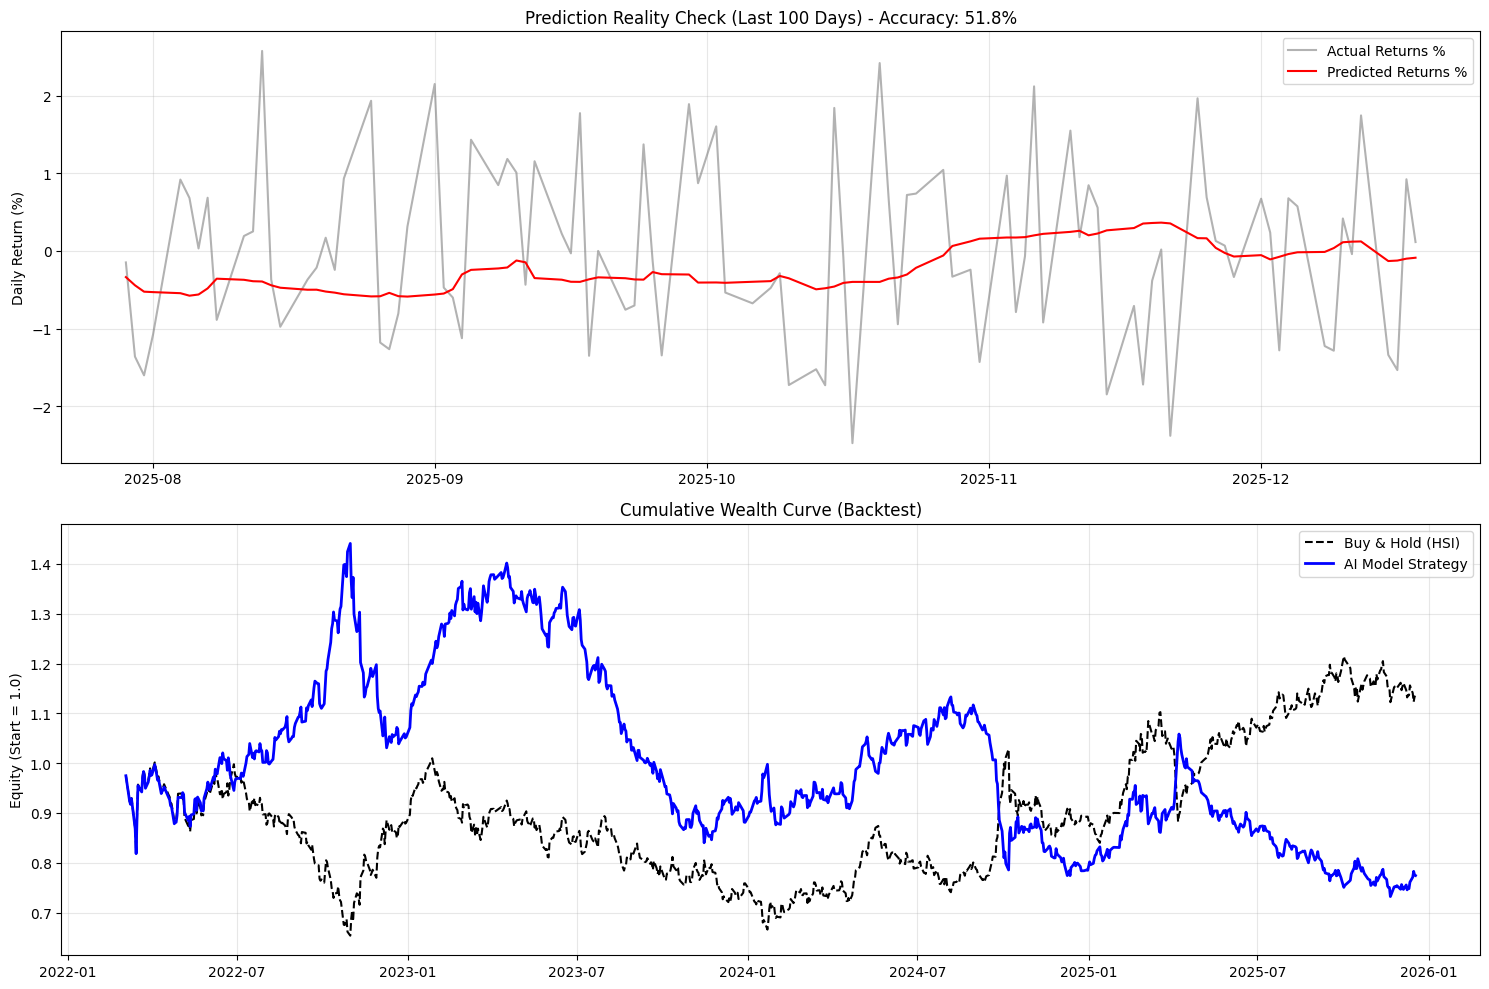


[Verdict / 最终诊断]
⚠️ 模型勉强及格，但可能扣除手续费后不赚钱。需要优化特征。


In [ ]:
# ============================================================
# STEP 4: VISUALIZATION & REALITY CHECK
# ============================================================
import matplotlib.pyplot as plt

print("\n[STEP 4] Reality Check: Visualizing & Backtesting...")

# 1. 反归一化 (Inverse Transform) - 双输出
# 这一步非常关键！我们要把模型输出的标准值还原成实际值
# 注意：test_pred 和 y_test 现在都是2列：[收益率, 波动率]
actual_returns = y_test_returns_denorm.flatten()  # 已在上一步反归一化
predicted_returns = test_pred_returns_denorm.flatten()  # 已在上一步反归一化
actual_volatility = y_test_volatility_denorm.flatten()
predicted_volatility = test_pred_volatility_denorm.flatten()

# 2. 计算方向准确率 (Directional Accuracy)
# 只要方向对(同为正或同为负)，就是赢
# 注意：实际为0的情况要处理，这里简化处理
hits = np.sign(actual_returns) == np.sign(predicted_returns)
accuracy = np.mean(hits) * 100

print("\n" + "="*40)
print("TRADING PERFORMANCE METRICS")
print("="*40)
print(f"1. Directional Accuracy: {accuracy:.2f}%")
print(f"   (> 50% is baseline, > 55% is good)")

# 3. 简单的策略回测 (Simple Vectorized Backtest)
# 策略：预测涨就买(持有1天)，预测跌就空(持有1天)
# 交易成本：假设每次万分之2 (0.02%)
cost_per_trade = 0.0002
signals = np.sign(predicted_returns)

# 策略收益 = 信号 * 实际涨跌 - 成本
strategy_returns = signals * (actual_returns / 100) - cost_per_trade
# 基准收益 (买入持有)
benchmark_returns = actual_returns / 100

# 计算累计收益曲线
equity_strategy = np.cumprod(1 + strategy_returns)
equity_benchmark = np.cumprod(1 + benchmark_returns)

print(f"2. Strategy Total Return: {(equity_strategy[-1] - 1)*100:.2f}%")
print(f"3. Buy & Hold Return:     {(equity_benchmark[-1] - 1)*100:.2f}%")

# 4. 绘图分析（包含置信区间）
plt.figure(figsize=(15, 12))

# 子图 1: 预测 vs 真实 + 置信区间 (局部放大看细节)
plt.subplot(3, 1, 1)
zoom_slice = slice(-100, None) # 只看最后100天，看得更清楚
zoom_dates = test_dates[zoom_slice]
zoom_actual = actual_returns[zoom_slice]
zoom_pred = predicted_returns[zoom_slice]
zoom_upper = confidence_upper[zoom_slice]
zoom_lower = confidence_lower[zoom_slice]

# 绘制置信区间（阴影区域）
plt.fill_between(zoom_dates, zoom_lower, zoom_upper, alpha=0.2, color='blue', label=f'{confidence_level*100:.0f}% Confidence Interval')
# 绘制实际值和预测值
plt.plot(zoom_dates, zoom_actual, label='Actual Returns %', color='grey', alpha=0.6, linewidth=1)
plt.plot(zoom_dates, zoom_pred, label='Predicted Returns %', color='red', linewidth=1.5)
plt.title(f'Prediction with Confidence Interval (Last 100 Days) - Direction Accuracy: {direction_accuracy:.1f}%')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图 2: 波动率预测 vs 真实
plt.subplot(3, 1, 2)
plt.plot(test_dates[zoom_slice], actual_volatility[zoom_slice], label='Actual Volatility %', color='grey', alpha=0.6, linewidth=1)
plt.plot(test_dates[zoom_slice], predicted_volatility[zoom_slice], label='Predicted Volatility %', color='orange', linewidth=1.5)
plt.title('Volatility Prediction (Last 100 Days)')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图 3: 累计收益曲线 (赚没赚钱?)
plt.subplot(3, 1, 3)
plt.plot(test_dates, equity_benchmark, label='Buy & Hold (HSI)', color='black', linestyle='--')
plt.plot(test_dates, equity_strategy, label='AI Model Strategy', color='blue', linewidth=2)
plt.title('Cumulative Wealth Curve (Backtest)')
plt.ylabel('Equity (Start = 1.0)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. 解释 R2 到底行不行
print("\n[Verdict / 最终诊断]")
if accuracy > 52 and equity_strategy[-1] > equity_benchmark[-1]:
    print("✅ 模型具备实战潜力！")
elif accuracy > 50:
    print("⚠️ 模型勉强及格，但可能扣除手续费后不赚钱。需要优化特征。")
else:
    print("❌ 模型目前不可用 (甚至不如抛硬币)")

In [10]:
# ============================================================
# STEP 4: ANALYZE PATTERN ATTENTION
# ============================================================
import numpy as np

# Get pattern names
pattern_names = patterns_df.columns.tolist()

# Average pattern attention across all test samples
avg_pattern_attention = np.mean(test_pattern_attn, axis=0)

print("\n" + "=" * 60)
print("PATTERN IMPORTANCE RANKING")
print("=" * 60)
print("\nWhich trading patterns does the model focus on?\n")

# Sort by importance
pattern_importance = list(zip(pattern_names, avg_pattern_attention))
pattern_importance.sort(key=lambda x: x[1], reverse=True)

for i, (pattern, weight) in enumerate(pattern_importance, 1):
    bar = '█' * int(weight * 200)
    print(f"{i:2d}. {pattern:<25} {weight:.4f} {bar}")

# Show specific prediction examples
print("\n" + "=" * 60)
print("EXAMPLE PREDICTIONS WITH PATTERN ATTENTION")
print("=" * 60)

y_test_flat = y_test.flatten()
test_pred_flat = test_pred.flatten()

# 随机选择 5 个样本
sample_indices = np.random.choice(len(test_pred_flat), 5, replace=False)

for idx in sample_indices:
    if idx < len(test_dates):
        date = test_dates[idx]

        actual_val = float(y_test_flat[idx])
        predicted_val = float(test_pred_flat[idx])

        print(f"\n{'='*60}")
        print(f"Date: {date.date()}")
        print(f"Actual Return: {actual_val:.4f}% | Predicted Return: {predicted_val:.4f}%")
        print(f"\nTop 5 Patterns the Model Focused On:")

        # Get pattern attention for this sample
        sample_pattern_attn = test_pattern_attn[idx]

        # Sort patterns by attention
        sample_importance = list(zip(pattern_names, sample_pattern_attn))
        sample_importance.sort(key=lambda x: x[1], reverse=True)

        for i, (pattern, weight) in enumerate(sample_importance[:5], 1):
            pct = weight * 100
            bar = '█' * int(weight * 100)
            print(f"  {i}. {pattern:<25} {pct:>5.1f}% {bar}")


PATTERN IMPORTANCE RANKING

Which trading patterns does the model focus on?

 1. RSI_Trend                 0.0388 ███████
 2. MACD_Bearish_Cross        0.0357 ███████
 3. BB_Position               0.0330 ██████
 4. DXY_Trend                 0.0318 ██████
 5. Vol_Price_Trend_Sync      0.0290 █████
 6. Vol_Rel_5                 0.0278 █████
 7. Sentiment_Fear_Rank       0.0272 █████
 8. Vol_Bias_20               0.0248 ████
 9. Outside_Day               0.0239 ████
10. ADX                       0.0207 ████
11. US10Y_Change              0.0203 ████
12. MACD_Hist_Slope           0.0202 ████
13. BB_Touch_Lower            0.0199 ███
14. Vol_Trend_Consistency     0.0199 ███
15. BB_Touch_Upper            0.0185 ███
16. 3Day_Uptrend              0.0155 ███
17. Drawdown_Bounce           0.0153 ███
18. BB_Width_Compressed       0.0148 ██
19. HSI_SPX_Ratio_Dev         0.0144 ██
20. Log_Ret                   0.0139 ██
21. Vol_Pullback_Low          0.0139 ██
22. Market_Up_Down_Ratio      0.0137 ██


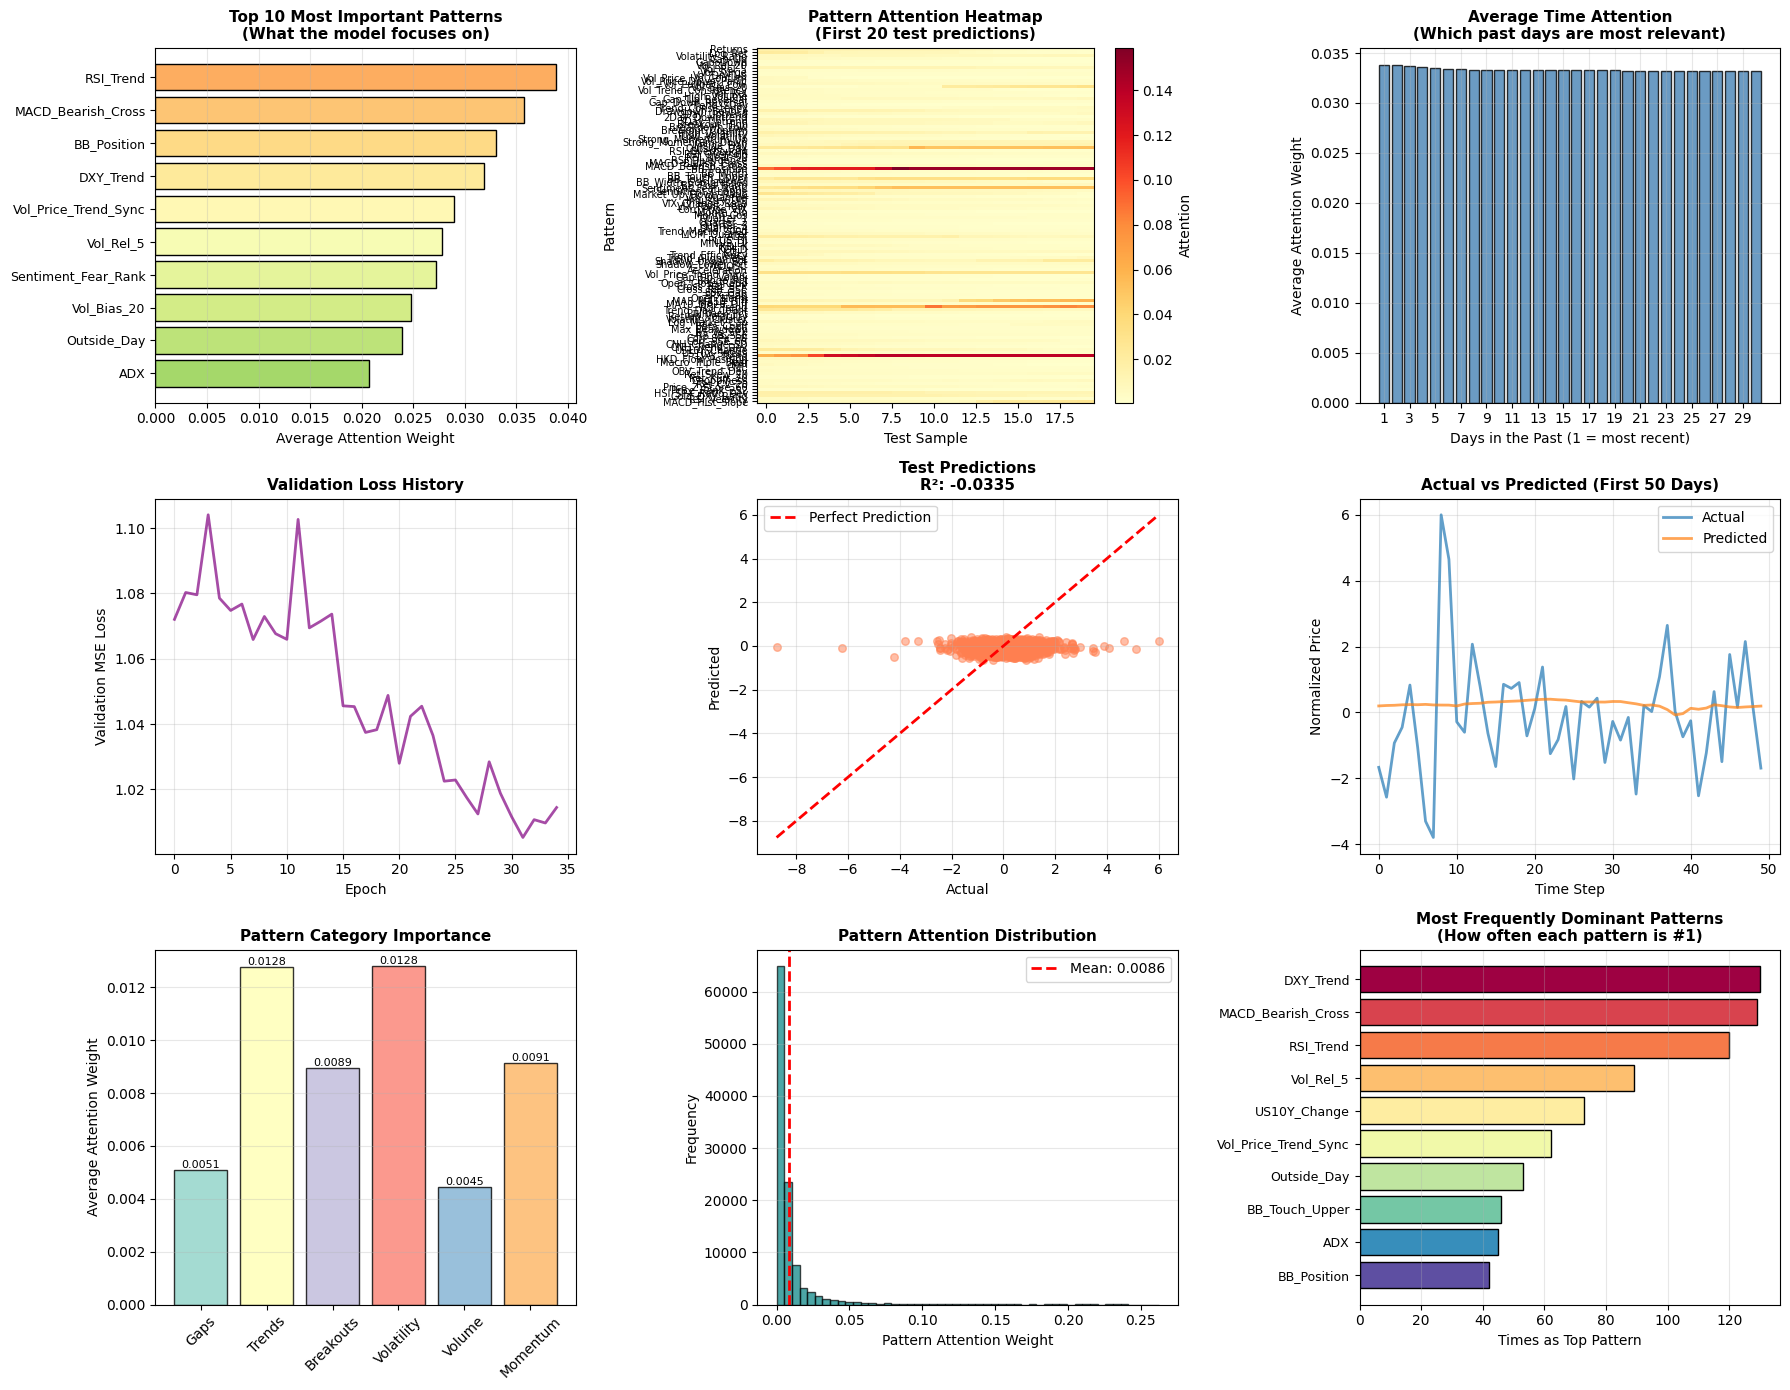


PATTERN CATEGORY ANALYSIS
Volatility      0.0128
Trends          0.0128
Momentum        0.0091
Breakouts       0.0089
Gaps            0.0051
Volume          0.0045


In [11]:
# ============================================================
# STEP 5: CREATE COMPREHENSIVE VISUALIZATIONS
# ============================================================


y_test_patterns = y_test.flatten()
test_pred_flat = test_pred.flatten()
avg_pattern_attention = np.mean(test_pattern_attn, axis=0)
pattern_importance = list(zip(pattern_names, avg_pattern_attention))
pattern_importance.sort(key=lambda x: x[1], reverse=True)
losses = [{'val_loss_mse': loss} for loss in train_losses]

fig = plt.figure(figsize=(18, 14))

# 1. Pattern Importance Bar Chart
ax1 = plt.subplot(3, 3, 1)
top_10_patterns = pattern_importance[:10]
patterns_top10 = [p[0] for p in top_10_patterns]
weights_top10 = [p[1] for p in top_10_patterns]

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.7, 10))
bars = ax1.barh(range(len(patterns_top10)), weights_top10, color=colors, edgecolor='black')
ax1.set_yticks(range(len(patterns_top10)))
ax1.set_yticklabels(patterns_top10, fontsize=9)
ax1.set_xlabel('Average Attention Weight', fontsize=10)
ax1.set_title('Top 10 Most Important Patterns\n(What the model focuses on)',
              fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2. Pattern Attention Heatmap (sample predictions)
ax2 = plt.subplot(3, 3, 2)
sample_size = 20
sample_attn = test_pattern_attn[:sample_size]

im = ax2.imshow(sample_attn.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax2.set_xlabel('Test Sample', fontsize=10)
ax2.set_ylabel('Pattern', fontsize=10)
ax2.set_yticks(range(len(pattern_names)))
ax2.set_yticklabels(pattern_names, fontsize=7)
ax2.set_title('Pattern Attention Heatmap\n(First 20 test predictions)',
              fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax2, label='Attention')

# 3. Time Attention Distribution
ax3 = plt.subplot(3, 3, 3)
avg_time_attention = np.mean(test_time_attn, axis=0)
days_back = np.arange(1, len(avg_time_attention) + 1) # 1-indexed for clarity in plotting

ax3.bar(days_back, avg_time_attention, alpha=0.8, color='steelblue', edgecolor='black')
ax3.set_xlabel('Days in the Past (1 = most recent)', fontsize=10)
ax3.set_ylabel('Average Attention Weight', fontsize=10)
ax3.set_title('Average Time Attention\n(Which past days are most relevant)',
              fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(days_back[::2]) # Show fewer x-ticks for readability

# 4. Training Loss
ax4 = plt.subplot(3, 3, 4)
val_losses = [l['val_loss_mse'] for l in losses] # Extract validation loss
ax4.plot(val_losses, linewidth=2, color='purple', alpha=0.7)
ax4.set_xlabel('Epoch', fontsize=10)
ax4.set_ylabel('Validation MSE Loss', fontsize=10) # Updated label
ax4.set_title('Validation Loss History', fontsize=11, fontweight='bold') # Updated title
ax4.grid(True, alpha=0.3)

# 5. Predictions vs Actual
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(y_test_patterns, test_pred, alpha=0.5, s=30, color='coral')
ax5.plot([y_test_patterns.min(), y_test_patterns.max()], [y_test_patterns.min(), y_test_patterns.max()],
         'r--', lw=2, label='Perfect Prediction')
ax5.set_xlabel('Actual', fontsize=10)
ax5.set_ylabel('Predicted', fontsize=10)
ax5.set_title(f'Test Predictions\nR²: {test_r2:.4f}', fontsize=11, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Time Series Predictions
ax6 = plt.subplot(3, 3, 6)
plot_range = slice(0, 50)
ax6.plot(y_test_patterns[plot_range], label='Actual', linewidth=2, alpha=0.7)
ax6.plot(test_pred[plot_range], label='Predicted', linewidth=2, alpha=0.7)
ax6.set_xlabel('Time Step', fontsize=10)
ax6.set_ylabel('Normalized Price', fontsize=10)
ax6.set_title('Actual vs Predicted (First 50 Days)', fontsize=11, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Pattern Category Analysis
ax7 = plt.subplot(3, 3, 7)
# Group patterns by category
categories = {
    'Gaps': ['Gap_Up', 'Gap_Down', 'Gap_Up_Reversal', 'Gap_Down_Reversal'],

    'Trends': ['2Day_Uptrend', '2Day_Downtrend', '3Day_Uptrend', '3Day_Downtrend',
               'Trend_Score_3D', 'MACD_Bullish_Cross', 'MACD_Bearish_Cross'],

    'Breakouts': ['Breakout_High', 'Breakdown_Low', 'Drawdown_Bounce',
                  'Dist_from_High', 'Dist_from_Low'],

    'Volatility': ['High_Volatility', 'Low_Volatility', 'Inside_Day', 'Outside_Day',
                   'Volatility_ATR_Ratio', 'BB_Width_Compressed'],

    'Volume': ['High_Volume', 'Low_Volume', 'Volume_Change', 'Vol_Rel'],

    'Momentum': ['Strong_Momentum_Up', 'Strong_Momentum_Down', 'Returns', 'Log_Ret',
                 'RSI_Overbought', 'RSI_Oversold', 'RSI_Near_50', 'RSI_Score',
                 'BB_Touch_Upper', 'BB_Touch_Lower', 'BB_Z_Score']
}

category_weights = {}
for cat, patterns in categories.items():
    weights = [avg_pattern_attention[pattern_names.index(p)] for p in patterns if p in pattern_names]
    category_weights[cat] = np.mean(weights)

cats = list(category_weights.keys())
cat_weights = list(category_weights.values())

colors_cat = plt.cm.Set3(range(len(cats)))
bars = ax7.bar(cats, cat_weights, color=colors_cat, edgecolor='black', alpha=0.8)
ax7.set_ylabel('Average Attention Weight', fontsize=10)
ax7.set_title('Pattern Category Importance', fontsize=11, fontweight='bold')
ax7.tick_params(axis='x', rotation=45)
ax7.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 8. Attention Distribution
ax8 = plt.subplot(3, 3, 8)
all_pattern_attn = test_pattern_attn.flatten()
ax8.hist(all_pattern_attn, bins=50, color='teal', alpha=0.7, edgecolor='black')
ax8.axvline(np.mean(all_pattern_attn), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(all_pattern_attn):.4f}')
ax8.set_xlabel('Pattern Attention Weight', fontsize=10)
ax8.set_ylabel('Frequency', fontsize=10)
ax8.set_title('Pattern Attention Distribution', fontsize=11, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# 9. Top Patterns Over Time
ax9 = plt.subplot(3, 3, 9)
# Track which pattern gets highest attention for each prediction
top_pattern_per_sample = np.argmax(test_pattern_attn, axis=1)
pattern_counts = {}
for pattern_idx in top_pattern_per_sample:
    pattern_name = pattern_names[pattern_idx]
    pattern_counts[pattern_name] = pattern_counts.get(pattern_name, 0) + 1

# Sort and plot top 10
sorted_counts = sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_patterns = [p[0] for p in sorted_counts]
top_counts = [p[1] for p in sorted_counts]

colors_top = plt.cm.Spectral(np.linspace(0, 1, len(top_patterns)))
bars = ax9.barh(range(len(top_patterns)), top_counts, color=colors_top, edgecolor='black')
ax9.set_yticks(range(len(top_patterns)))
ax9.set_yticklabels(top_patterns, fontsize=9)
ax9.set_xlabel('Times as Top Pattern', fontsize=10)
ax9.set_title('Most Frequently Dominant Patterns\n(How often each pattern is #1)',
              fontsize=11, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='x')
ax9.invert_yaxis()

plt.tight_layout()
plt.savefig('pattern_attention_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("PATTERN CATEGORY ANALYSIS")
print("=" * 60)
for cat, weight in sorted(category_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"{cat:<15} {weight:.4f}")


STEP 7: SIMULATING THE FUTURE (PATTERN-AWARE AI)
current date: 2025-12-18 00:00:00
Starting simulation from: 2025-12-18
Last Close Price: 25498.13
Starting simulation from: 2025-12-18
Last Close Price: 25498.13

Simulating 15 trading days into the future...

--------------------------------------------------
🔮 TOMORROW'S PATTERN ATTENTION (Forecast Day 1)
--------------------------------------------------
 1. MACD_Bearish_Cross        22.03%
 2. Vol_Rel_5                  6.94%
 3. KDJ_D                      3.37%
 4. Inside_Day                 2.86%
 5. Shadow_Lower_Pct           2.66%
 6. DXY_Trend                  2.42%
 7. MACD_Hist_Slope            2.14%
 8. RSI_Trend                  2.03%
 9. Vol_Price_Up_Confirm       1.74%
10. 2Day_Downtrend             1.62%

Time Attention Peak: Index 1 (0=Oldest, 19=Yesterday)
--------------------------------------------------

Day 5/15: Predicted +0.03%, Price 25437.84
Day 10/15: Predicted +0.19%, Price 25621.67
Day 15/15: Predicted -0.02

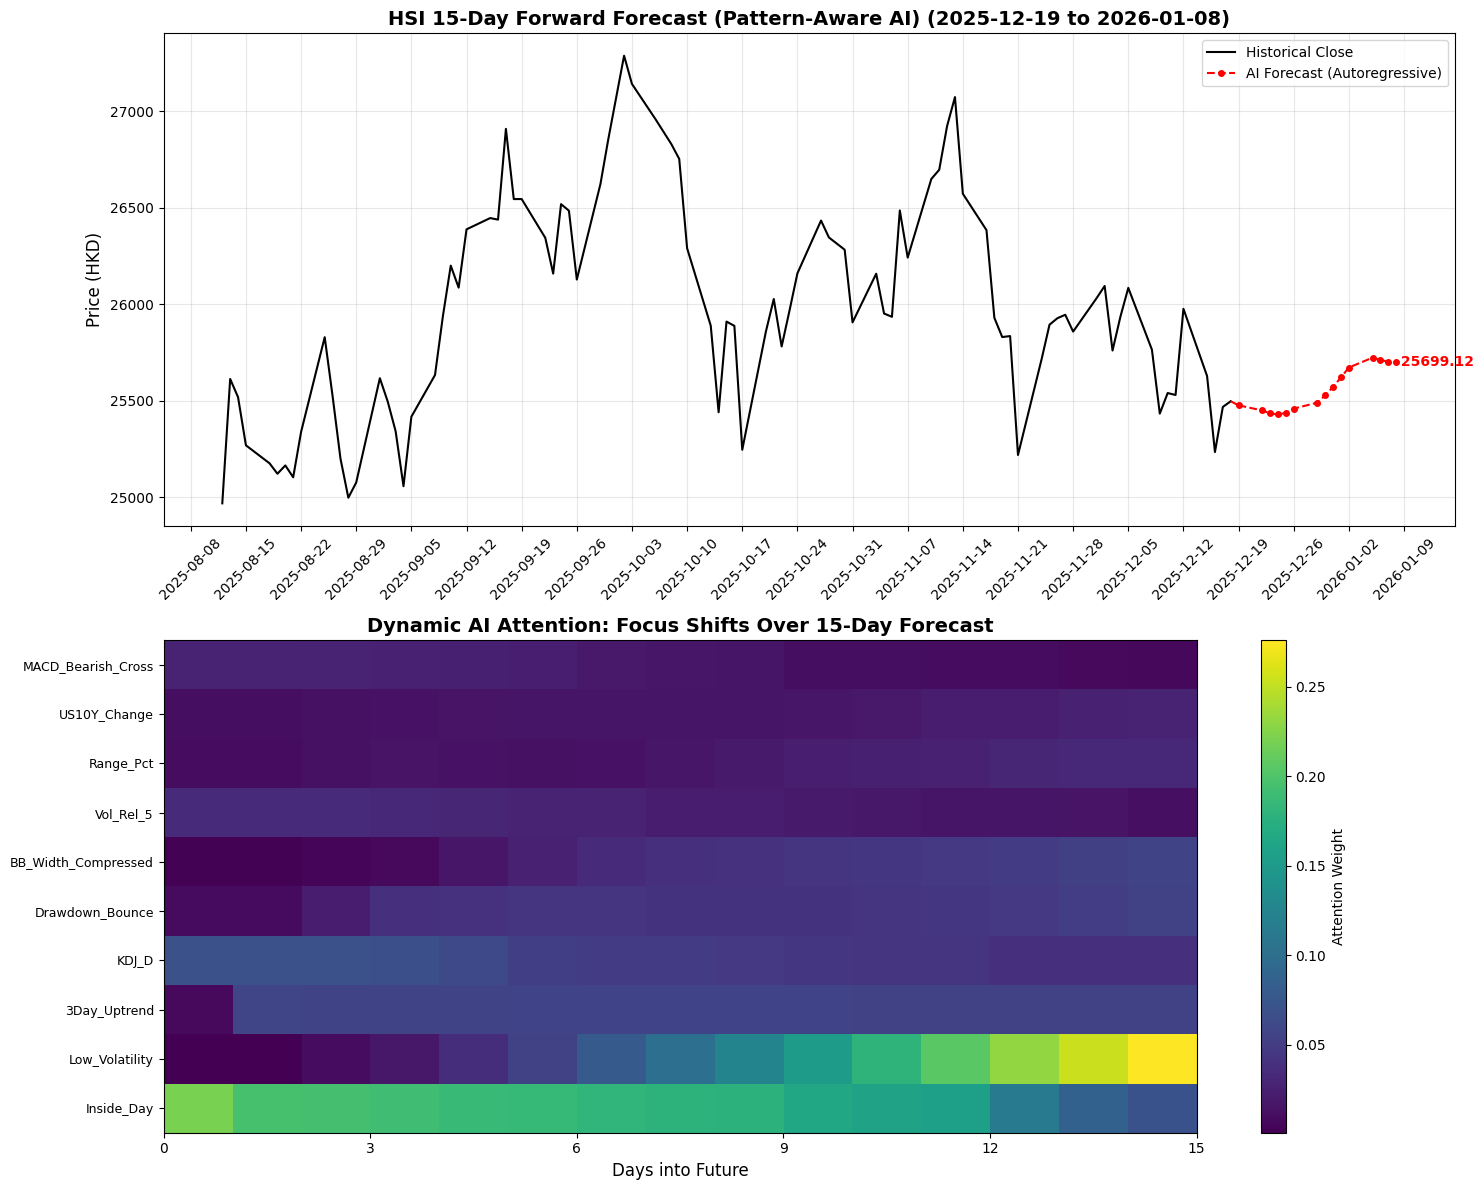


FORECAST DATA TABLE
      Date  Forecast_Price (HKD)  Predicted_Change (%)
2025-12-19              25477.13                 -0.08
2025-12-22              25450.45                 -0.19
2025-12-23              25435.51                 -0.25
2025-12-24              25429.91                 -0.27
2025-12-25              25437.84                 -0.24
2025-12-26              25460.09                 -0.15
2025-12-29              25490.96                 -0.03
2025-12-30              25529.49                  0.12
2025-12-31              25573.09                  0.29
2026-01-01              25621.67                  0.48
2026-01-02              25672.85                  0.69
2026-01-05              25723.77                  0.88
2026-01-06              25711.35                  0.84
2026-01-07              25703.59                  0.81
2026-01-08              25699.12                  0.79
Final Forecast Price: 25699.12 HKD
Total Predicted Change: +0.79%


In [ ]:
# ============================================================
# STEP 7: AUTOREGRESSIVE FORECAST (WITH TOMORROW'S ATTENTION)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import BDay

print("\n" + "=" * 70)
print("STEP 7: SIMULATING THE FUTURE (PATTERN-AWARE AI)")
print("=" * 70)

# -------------------------- 补充核心依赖（纯pandas，无额外库） --------------------------
# 1. 替代pandas_market_calendars：用BDay+手动过滤生成交易日（兼容香港股市周末休市）
def get_next_trading_day(current_date):
    """
    生成下一个交易日（跳过周末，用BDay实现，纯pandas原生）
    current_date: 当前日期（datetime类型）
    返回：下一个交易日（datetime类型）
    """
    next_day = current_date + BDay(1)
    return next_day

# -------------------------- 核心预测逻辑（修复后） --------------------------
# 1. 配置参数
FORECAST_DAYS = 15
SEQUENCE_LENGTH = 20

# 2. 准备初始数据（确保索引为datetime类型）
history_df = df.copy()
current_date =history_df.index[-1]
print("current date:",current_date)
last_close_price = history_df['Close'].iloc[-1]

if not pd.api.types.is_datetime64_any_dtype(history_df.index):
    history_df.index = pd.to_datetime(history_df.index)  # 强制转换为datetime索引
current_date = history_df.index[-1]
last_close_price = history_df['Close'].iloc[-1]

# 获取特征名称列表
feature_names = detect_trading_patterns(history_df).columns.tolist()
assert len(feature_names) == 116, f"特征数量应为116，实际为{len(feature_names)}（与Step 2不一致）"

print(f"Starting simulation from: {current_date.date()}")
print(f"Last Close Price: {last_close_price:.2f}")

# 存储推演结果
future_dates = []
future_prices = []
future_attentions = []

feature_names = patterns_df.columns.tolist()
print(f"Starting simulation from: {current_date.date()}")
print(f"Last Close Price: {last_close_price:.2f}")

# 存储推演结果
future_dates = []
future_prices = []
future_attentions = []

# 确保模型处于评估模式
model.eval()

print(f"\nSimulating {FORECAST_DAYS} trading days into the future...")

# ---------------------------------------------------------
# AUTOREGRESSIVE LOOP (自回归循环)
# ---------------------------------------------------------
for i in range(FORECAST_DAYS):
    # A. 动态特征工程，计算新的pattern
    current_patterns = detect_trading_patterns(history_df)

    # B. 准备模型输入（确保序列长度和归一化正确）
    if len(current_patterns) < SEQUENCE_LENGTH:
        raise ValueError(f"历史数据不足{SEQUENCE_LENGTH}天，无法生成输入序列")
    last_seq_raw = current_patterns.iloc[-SEQUENCE_LENGTH:].values
    last_seq_scaled = scaler.transform(last_seq_raw)
    input_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

    # C. 模型预测（双输出：收益率 + 波动率）
    with torch.no_grad():
        pred_tensor, p_attn, t_attn = model(input_tensor)
        # pred_tensor 现在是2维：[收益率, 波动率]
        pred_returns_scaled = pred_tensor[0, 0].item()  # 收益率（标准化后）
        pred_volatility_scaled = pred_tensor[0, 1].item()  # 波动率（标准化后）
        
        # 反归一化
pred_ret_pct = scaler_target_returns.inverse_transform([[pred_returns_scaled]])[0, 0]

# 波动率反归一化（根据归一化方法选择）
if VOLATILITY_SCALING_METHOD == 'log_standard':
    # 对数变换的反归一化
    pred_vol_pct = np.expm1(scaler_target_volatility.inverse_transform([[pred_volatility_scaled]])[0, 0])
else:
    # 标准反归一化
    pred_vol_pct = scaler_target_volatility.inverse_transform([[pred_volatility_scaled]])[0, 0]
        
        # 不限制预测值（按用户要求取消限制）
        # 但可以添加警告
        if abs(pred_ret_pct) > 10:
            print(f"⚠️ Warning: Extreme return prediction: {pred_ret_pct:.2f}%")
        
        avg_p_attn = p_attn.mean(dim=1).cpu().numpy().flatten()

        # 展示第一天(明天)的关注点
        if i == 0:
            print("\n" + "-"*50)
            print("🔮 TOMORROW'S PATTERN ATTENTION (Forecast Day 1)")
            print("-"*50)

            # 排序并打印Top 10
            day1_importance = list(zip(feature_names, avg_p_attn))
            day1_importance.sort(key=lambda x: x[1], reverse=True)

            for rank, (name, weight) in enumerate(day1_importance[:10], 1):
                print(f"{rank:2d}. {name:<25} {weight*100:5.2f}%")

            # 打印时间关注点
            avg_t_attn = t_attn.squeeze().cpu().numpy()
            peak_day = np.argmax(avg_t_attn)
            print(f"\nTime Attention Peak: Index {peak_day} (0=Oldest, {SEQUENCE_LENGTH-1}=Yesterday)")
            print("-"*50 + "\n")

    # D. 还原价
    new_price = last_close_price * (1 + pred_ret_pct / 100)
    new_price = max(new_price, 0.01)

    # E. 构造新的一行数据（完善所有必要列）
    next_date = get_next_trading_day(current_date)

    # 计算辅助指标（用于后续特征生成）
    recent_window = history_df.iloc[-20:]

    recent_atr = recent_window[['High', 'Low', 'Close']].apply(
        lambda x: max(x.iloc[0]-x.iloc[1], abs(x.iloc[0]-x.iloc[2]), abs(x.iloc[1]-x.iloc[2])),
        axis=1
    ).mean()
    recent_atr = recent_atr if not np.isnan(recent_atr) and recent_atr > 0 else last_close_price * 0.01
    recent_vol = recent_window['Volume'].mean() if not np.isnan(recent_window['Volume'].mean()) else 1e6

    # 构造新行
    new_row = pd.DataFrame({
        'Open': [new_price],
        'High': [new_price + recent_atr * 0.5],
        'Low': [new_price - recent_atr * 0.5],
        'Close': [new_price],
        'Volume': [recent_vol],
        'Log_Ret': [np.log(new_price / last_close_price)]
    }, index=[next_date])

    for col in history_df.columns:
        if col not in new_row.columns and col != 'Target':
            new_row[col] = 0.0

    # F. 更新状态
    history_df = pd.concat([history_df, new_row], ignore_index=False)
    current_date = next_date
    last_close_price = new_price

    # 记录结果
    future_dates.append(next_date)
    future_prices.append(new_price)
    future_attentions.append(avg_p_attn)

    # 打印进度
    if (i+1) % 5 == 0:
        print(f"Day {i+1}/{FORECAST_DAYS}: Predicted {pred_ret_pct:+.2f}%, Price {new_price:.2f}")

# ============================================================
# VISUALIZATION
# ============================================================
print("\n[PLOTTING FORECAST]")

plt.figure(figsize=(15, 12))

# 1. Price Forecast Chart
plt.subplot(2, 1, 1)
recent_history = df.iloc[-90:]
plt.plot(recent_history.index, recent_history['Close'], label='Historical Close', color='black', linewidth=1.5)
plt.plot(future_dates, future_prices, label='AI Forecast (Autoregressive)', color='red', linestyle='--', marker='o', markersize=4, linewidth=1.5)

# 连接历史与预测数据
plt.plot([recent_history.index[-1], future_dates[0]],
         [recent_history['Close'].iloc[-1], future_prices[0]],
         color='red', linestyle='--', linewidth=1.5)

# 添加最终价格标签
plt.text(future_dates[-1], future_prices[-1], f" {future_prices[-1]:.2f}",
         color='red', fontweight='bold', va='center', fontsize=10)

# Get forecast date range from future_dates
forecast_start_date_plot = future_dates[0].strftime('%Y-%m-%d')
forecast_end_date_plot = future_dates[-1].strftime('%Y-%m-%d')
plot_title_suffix = f" ({forecast_start_date_plot} to {forecast_end_date_plot})"

plt.title(f'{ticker.ticker.replace('^', '')} 15-Day Forward Forecast (Pattern-Aware AI){plot_title_suffix}', fontsize=14, fontweight='bold')
plt.ylabel('Price (HKD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
# 格式化x轴日期
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))
plt.xticks(rotation=45)

# 2. Future Attention Heatmap
plt.subplot(2, 1, 2)
attn_matrix = np.array(future_attentions)

# 只显示平均注意力最高的10个特征（避免图表拥挤）
avg_sim_attn = np.mean(attn_matrix, axis=0)
top_idx = np.argsort(avg_sim_attn)[-10:]  # 取Top 10特征的索引
top_names = [feature_names[i] for i in top_idx]
top_matrix = attn_matrix[:, top_idx]

# 绘制热力图
im = plt.imshow(top_matrix.T, aspect='auto', cmap='viridis', interpolation='nearest',
                extent=[0, FORECAST_DAYS, 0, 10])

plt.yticks(np.arange(0.5, 10.5, 1), top_names, fontsize=9)
plt.xlabel('Days into Future', fontsize=12)
plt.title('Dynamic AI Attention: Focus Shifts Over 15-Day Forecast', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Attention Weight')
# x轴刻度与预测天数对应
plt.xticks(range(0, FORECAST_DAYS+1, 3))

plt.tight_layout()
plt.show()

# 3. Output Table（优化格式）
forecast_df = pd.DataFrame({
    'Date': [d.date() for d in future_dates],
    'Forecast_Price (HKD)': [round(p, 2) for p in future_prices],
    'Predicted_Change (%)': [round((p - df['Close'].iloc[-1])/df['Close'].iloc[-1]*100, 2) for p in future_prices]
})

print("\n" + "=" * 60)
print("FORECAST DATA TABLE")
print("=" * 60)
print(forecast_df.to_string(index=False))
print("=" * 60)
print(f"Final Forecast Price: {future_prices[-1]:.2f} HKD")
print(f"Total Predicted Change: {(future_prices[-1] - df['Close'].iloc[-1])/df['Close'].iloc[-1]*100:+.2f}%")



STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)
请输入要回测的股票/指数代码（默认：^HSI 恒生指数）：
未输入代码，使用默认值：^HSI（恒生指数）

正在验证代码 ^HSI 的有效性...
✅ 代码 ^HSI 验证通过！
   [FIX] Fetching VIX (^HSIL) and external assets...
   Dropped 0 rows due to NaNs or zero volume.
   [Re-initialized] df has 1229 rows.
   [Re-initialized] patterns_df has 1229 rows and 116 features.
   Using Device: cpu
   使用生成的 patterns_df：共 116 个特征
   最新数据日期: 2025-12-18
   总交易天数: 1229

🚀 Running Scenario: [Reserve 1 Month]
   Cutoff Date: 2025-11-18
   训练序列数: 1186 | 验证集天数: 22
   Training model... Done (Final Loss: 0.000294)
   Simulating 67 days (Holdout: 22, Future: 45)...

🚀 Running Scenario: [Reserve 15 Days]
   Cutoff Date: 2025-11-27
   训练序列数: 1193 | 验证集天数: 15
   Training model... Done (Final Loss: 0.000288)
   Simulating 60 days (Holdout: 15, Future: 45)...

🚀 Running Scenario: [All Data]
   Cutoff Date: 2025-12-18
   训练序列数: 1208 | 验证集天数: 0
   Training model... Done (Final Loss: 0.000270)
   Simulating 45 days (Holdout: 0, Future: 45).

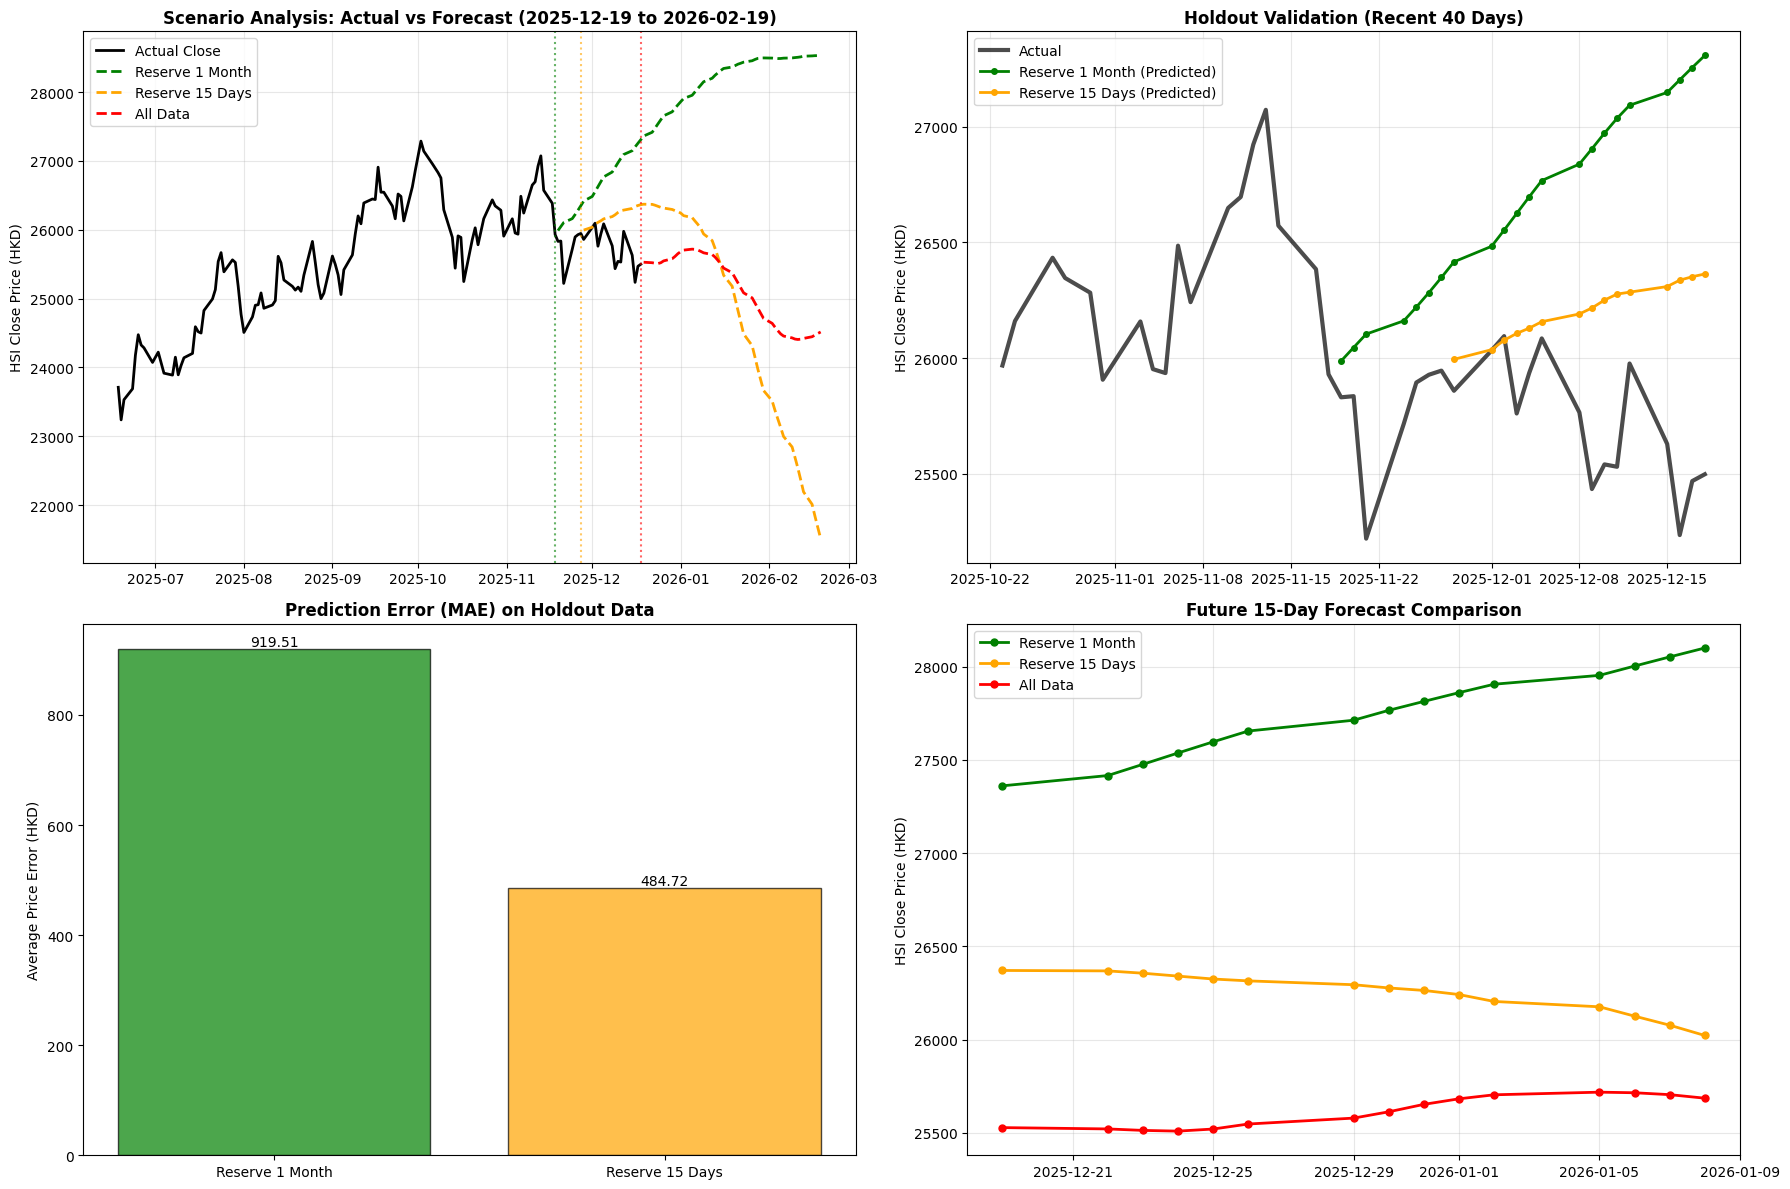


=== SCENARIO BACKTESTING SUMMARY ===

📊 [Reserve 1 Month]
   Training Cutoff: 2025-11-18
   Train Sequences: 1186
   Holdout Days: 22
   Holdout MAE: 919.51 HKD
   Top 10 Important Patterns (Attention Weight):
      1. Acceleration                     2.67%
      2. KDJ_K                            1.84%
      3. Vol_Rel_5                        1.76%
      4. RS_vs_SPX                        1.65%
      5. High_Volume                      1.47%
      6. Corr_SPX_60                      1.46%
      7. Gold_DXY_Ratio                   1.37%
      8. Gap_Down                         1.37%
      9. Trend_Alignment                  1.37%
     10. BB_Position                      1.34%
   Time Attention Peak: Day 0 (0=Oldest, 19=Yesterday)

📊 [Reserve 15 Days]
   Training Cutoff: 2025-11-27
   Train Sequences: 1193
   Holdout Days: 15
   Holdout MAE: 484.72 HKD
   Top 10 Important Patterns (Attention Weight):
      1. Trend_Alignment                  1.93%
      2. Shadow_Upper_Pct        

In [14]:
# ============================================================
# STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from pandas.tseries.offsets import BDay
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from datetime import datetime, timedelta

print("\n" + "=" * 70)
print("STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)")
print("=" * 70)

# ====================================================================
# 【修复 1】 数据初始化和外部资产合并 (必须匹配 detect_trading_patterns 的输入)
# ====================================================================
# 1. 基础输入（带默认值，回车直接用恒生指数）
ticker_symbol = input("请输入要回测的股票/指数代码（默认：^HSI 恒生指数）：").strip()
# 2. 空输入时用默认值
if not ticker_symbol:
    ticker_symbol = "^HSI"
    print(f"未输入代码，使用默认值：{ticker_symbol}（恒生指数）")

# 3. 输入校验（检查yfinance是否能获取该代码的数据）
print(f"\n正在验证代码 {ticker_symbol} 的有效性...")
temp_ticker = yf.Ticker(ticker_symbol)
temp_df = temp_ticker.history(period="1d")  # 仅获取1天数据验证

if temp_df.empty:
    # 校验失败，提示并强制使用默认值
    print(f"⚠️ 输入的代码 {ticker_symbol} 无效（无数据），自动切换为默认值 ^HSI")
    ticker_symbol = "^HSI"
    ticker = yf.Ticker(ticker_symbol)
else:
    # 校验成功，创建Ticker对象
    print(f"✅ 代码 {ticker_symbol} 验证通过！")
    ticker = yf.Ticker(ticker_symbol)

end_date = datetime.now()

#end_date = datetime.now()+timedelta(days=1)

start_date = end_date - timedelta(days=5*365) # 使用 5 年数据

# --- 1. 获取 HSI 基础数据 ---
df = ticker.history(start=start_date, end=end_date)

# --- NEW: Check if primary HSI data is empty ---
if df.empty:
    print("   ❌ Error: HSI data for the last 5 years is empty. Attempting a wider fetch (20 years).")
    start_date = end_date - timedelta(days=20*365)
    df = ticker.history(start=start_date, end=end_date)
    if df.empty:
        raise ValueError("Critical Error: HSI data could not be fetched even for 20 years. Cannot proceed.")

df.index = pd.to_datetime(df.index).tz_localize(None) # Ensure df index is tz-naive
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

# --- 2. 获取 VIX (^HSIL) 数据 ---
print("   [FIX] Fetching VIX (^HSIL) and external assets...")
vix_ticker = yf.Ticker("^HSIL")
vix_df = vix_ticker.history(start=start_date, end=end_date)
# Ensure vix_df index is tz-naive before joining
vix_df.index = pd.to_datetime(vix_df.index).tz_localize(None)
if not vix_df.empty:
    df = df.join(vix_df['Close'].rename('VIX_Close').shift(1), how='left')
else:
    print("      ⚠️ Warning: ^HSIL data is empty. Using fallback value 20.0.")
    df['VIX_Close'] = 20.0 # Fallback if VIX data is entirely missing

# --- 3. 获取其他外部资产数据 ---
tickers_dict = {
    'SPX_Close': '^GSPC', 'SSE_Close': '000001.SS',
    'USDCNH_Close': 'CNH=F', 'US10Y_Close': '^TNX',
    'USDHKD_Close': 'HKD=X', 'DXY_Close': 'DX-Y.NYB',
    'GOLD_Close': 'GC=F'
}
for col_name, ticker_symbol in tickers_dict.items():
    try:
        ext_df = yf.Ticker(ticker_symbol).history(start=start_date, end=end_date)
        # Ensure ext_df index is tz-naive before joining
        ext_df.index = pd.to_datetime(ext_df.index).tz_localize(None)
        if not ext_df.empty:
            df = df.join(ext_df['Close'].rename(col_name).shift(1), how='left')
        else:
            print(f"      ⚠️ Warning: {col_name} data is empty. Filling with NaN to be handled by later fillna.")
            df[col_name] = np.nan # Add as NaN if empty, will be filled next
    except Exception as e:
        print(f"      ❌ Error fetching {ticker_symbol}: {e}. Filling with NaN.")
        df[col_name] = np.nan

# --- 4. 最终清洗和填充 ---
external_cols = list(tickers_dict.keys()) + ['VIX_Close']

# Use ffill, then a rolling mean, then a final static fill for any remaining NaNs
df[external_cols] = df[external_cols].ffill()
# Calculate rolling mean BEFORE general fillna, on potentially existing data
for col in external_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].rolling(30, min_periods=1).mean())
# Final fill for any remaining NaNs, e.g., if first 30 days are NaN or if the rolling mean is NaN
# Use the column's mean as a last resort, but only for columns that exist
for col in external_cols:
    if col in df.columns and df[col].isnull().any():
        col_mean = df[col].mean()
        if not np.isnan(col_mean):
            df[col] = df[col].fillna(col_mean)
        else:
            # If even the mean is NaN (e.g., column is all NaNs), fill with a sensible default like 0 or 1.0
            # For prices/indices, 1.0 might be more appropriate than 0 to avoid division by zero later.
            df[col] = df[col].fillna(1.0) # Fallback to 1.0 for price-like data if all else fails


# Recalculate external asset returns, ensuring no NaNs from empty data after processing
df['SPX_Ret'] = df['SPX_Close'].pct_change(fill_method=None).fillna(0)
df['SSE_Ret'] = df['SSE_Close'].pct_change(fill_method=None).fillna(0)

# Critical step: filter out rows with any NaNs *only after* all attempts to fill have been made.
# Also ensure there's still data after filtering.
original_df_rows = len(df)
df = df.dropna(subset=['Close', 'Open', 'High', 'Low'] + external_cols)
if df.empty:
    raise ValueError("Critical Error: DataFrame became empty after dropping rows with NaNs in essential columns. Data too sparse to proceed.")
else:
   latest_date = df.index[-1].date()
print(f"   Dropped {original_df_rows - len(df)} rows due to NaNs or zero volume.")

df = df[
    (df['Volume'] > 0) |  # 非最新日期：Volume必须大于0
    (df.index.date == latest_date)  # 最新日期：允许Volume=0
]

# 3. 填充最新日期的0成交量为前一日值
if (df.index.date == latest_date).any():  # 确认最新日期行存在
    latest_volume = df.loc[df.index.date == latest_date, 'Volume'].iloc[0]
    if latest_volume == 0:
        # 取前一日的Volume值填充
        prev_volume = df.loc[df.index.date < latest_date, 'Volume'].iloc[-1]
        print(f"⚠️ 最新日期 {latest_date} 的Volume为0，已填充为前一日值: {prev_volume}")
        manual_input = input(f"请输入该日期的Volume值（回车默认使用前一日有效值：{prev_volume}）：").strip()

        try:
            if manual_input == "":  # 无输入，用默认值
                fill_volume = prev_volume
                print(f"✅ 未输入值，自动填充为前一日Volume：{fill_volume}")
            else:  # 有输入，转换为数值
                fill_volume = float(manual_input)
                print(f"✅ 已使用手动输入值填充：{fill_volume}")
        except ValueError:  # 输入非数字，兜底用默认值
            fill_volume = prev_volume
            print(f"⚠️ 输入非数字，自动填充为前一日Volume：{fill_volume}")

        # 执行填充
        df.loc[df.index.date == latest_date, 'Volume'] = fill_volume

# 4. 最终校验：过滤后是否为空（兜底）
if df.empty:
    raise ValueError("Critical Error: DataFrame became empty after filtering for Volume > 0. No valid trading days.")

if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

# ====================================================================
# 重新生成 patterns_df
# ====================================================================

if 'detect_trading_patterns' not in globals():
    raise NameError("The 'detect_trading_patterns' function is not defined. Please ensure previous steps defining it have been executed.")

# Now that df is guaranteed not to be empty (or an error would have been raised)
patterns_df = detect_trading_patterns(df.copy()) # Generate patterns_df from the fresh df

# --- NEW: Check if patterns_df is empty ---
if patterns_df.empty:
    raise ValueError("Critical Error: patterns_df is empty after feature detection. Cannot proceed.")

# Ensure patterns_df and df align. If patterns_df lost some rows (e.g. due to internal calculations resulting in NaN),
# then df should also be adjusted.
original_patterns_rows = len(patterns_df)
patterns_df = patterns_df.dropna() # Ensure no NaNs in patterns_df features
if patterns_df.empty:
    raise ValueError("Critical Error: patterns_df became empty after dropping rows with NaNs. Features too sparse to proceed.")

if original_patterns_rows != len(patterns_df):
    print(f"   Dropped {original_patterns_rows - len(patterns_df)} rows from patterns_df due to internal NaNs.")

df = df.loc[patterns_df.index] # Align df to the cleaned patterns_df

if df.empty:
    raise ValueError("Critical Error: df became empty after aligning with patterns_df. Data too sparse.")

print(f"   [Re-initialized] df has {len(df)} rows.")
print(f"   [Re-initialized] patterns_df has {len(patterns_df)} rows and {patterns_df.shape[1]} features.")

# ===================== 关键配置 =====================
# 1. 定义设备（CPU/GPU自动检测）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Using Device: {device}")

# 2. 复用 patterns_df（现在已确保与 df 对齐）
print(f"   使用生成的 patterns_df：共 {patterns_df.shape[1]} 个特征")

# 3. 配置参数（优化训练稳定性）
lstm_sequence_length = 20
forecast_horizon_days = 45
comparison_horizon = 15
SCENARIO_EPOCHS = 50  # 足够训练轮数
LEARNING_RATE = 0.0005  # 低学习率避免震荡
WEIGHT_DECAY = 1e-5  # 权重衰减防过拟合

# 4. 获取基础数据（现在已确保是最新的df）
latest_date = df.index[-1]
print(f"   最新数据日期: {latest_date.date()}")
print(f"   总交易天数: {len(df)}")

# =====================  PatternAwareLSTM 模型   =====================
class PatternAwareLSTM(nn.Module):
    def __init__(self, num_patterns, hidden_size=64, num_layers=2, dropout=0.2):
        super(PatternAwareLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_patterns = num_patterns

        # 模式注意力层
        self.pattern_attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_patterns),
            nn.Softmax(dim=-1)
        )

        # 时间注意力层
        self.time_attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)  # 对时间步归一化
        )

        # 特征投影层（适配特征维度到LSTM输入）
        self.feature_projection = nn.Linear(num_patterns, hidden_size)

        # LSTM 层
        self.lstm = nn.LSTM(
            input_size=num_patterns,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # 输出层（预测收益率，限制范围）
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
            nn.Tanh()  # 输出[-1,1]，对应±100%收益率
        )

        # 权重初始化（避免训练不稳定）
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # x shape: (batch_size, seq_len, num_patterns)
        batch_size, seq_len, num_patterns = x.shape

        # 1. 特征投影（便于注意力计算）
        x_proj = self.feature_projection(x)  # (batch, seq, hidden_size)

        # 2. 模式注意力（核心修复：权重分散到所有特征）
        p_attn = self.pattern_attention(x_proj)  # (batch, seq, num_patterns)
        p_attn = p_attn / (p_attn.sum(dim=-1, keepdim=True) + 1e-8)  # 确保归一化
        x_p_attended = x * p_attn  # 特征加权

        # 3. LSTM 特征提取
        lstm_out, (hidden, cell) = self.lstm(x_p_attended)  # (batch, seq, hidden_size)

        # 4. 时间注意力
        t_attn = self.time_attention(lstm_out)  # (batch, seq, 1)
        t_attn = t_attn / (t_attn.sum(dim=1, keepdim=True) + 1e-8)
        x_t_attended = lstm_out * t_attn
        context = x_t_attended.sum(dim=1)  # (batch, hidden_size)

        # 5. 预测输出（缩放至合理收益率范围：±10%）
        out = self.fc(context) * 0.1

        return out, p_attn, t_attn

# ===================== 场景分析函数 =====================
def run_scenario_analysis(train_cutoff_date, label):

    print(f"\n🚀 Running Scenario: [{label}]")
    print(f"   Cutoff Date: {train_cutoff_date.date()}")

    # -----------------------------------------------------
    # 1. 数据切片
    # -----------------------------------------------------
    # 训练集/验证集切片
    train_mask = df.index <= train_cutoff_date
    train_df_scenario = df[train_mask].copy()
    holdout_df_real = df[~train_mask].copy()
    patterns_train_scenario = patterns_df[train_mask].copy()

    # 目标值：未来1日收益率（修复对齐逻辑）
    y_train_raw = train_df_scenario['Close'].pct_change().shift(-1).dropna().values  # 预测下一日收益率
    patterns_train_aligned = patterns_train_scenario.iloc[:-1].copy()
    y_train_raw = y_train_raw[:len(patterns_train_aligned)]

    if len(patterns_train_aligned) < lstm_sequence_length + 1:
        return {
            'label': label, 'train_cutoff': train_cutoff_date, 'mae': np.nan,
            'full_sim_df': pd.DataFrame(), 'forecast_15': pd.DataFrame(), 'pattern_summary': [],
            'train_sequences': 0, 'holdout_sequences': 0, 'ohclv_forecast': pd.DataFrame(),
            'time_attention': None
        }

    # 特征标准化（仅用训练集拟合，避免数据泄露）
    local_scaler = StandardScaler()
    X_train_scaled = local_scaler.fit_transform(patterns_train_aligned.values)
    y_train_raw = y_train_raw.reshape(-1, 1)

    # 创建LSTM序列数据
    X_seq, y_seq = [], []
    for i in range(len(X_train_scaled) - lstm_sequence_length):
        X_seq.append(X_train_scaled[i:i+lstm_sequence_length])
        y_seq.append(y_train_raw[i+lstm_sequence_length])

    X_train_tensor = torch.FloatTensor(np.array(X_seq)).to(device)
    y_train_tensor = torch.FloatTensor(np.array(y_seq)).to(device)
    print(f"   训练序列数: {len(X_seq)} | 验证集天数: {len(holdout_df_real)}")

    # -----------------------------------------------------
    # 2. 模型训练
    # -----------------------------------------------------
    local_model = PatternAwareLSTM(num_patterns=patterns_df.shape[1], hidden_size=64).to(device)
    optimizer = optim.Adam(
        local_model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    criterion = nn.MSELoss()  # 回归任务用MSE

    local_model.train()
    print(f"   Training model...", end="")
    for epoch in range(SCENARIO_EPOCHS):
        optimizer.zero_grad()
        out, _, _ = local_model(X_train_tensor)
        loss = criterion(out, y_train_tensor)
        loss.backward()
        optimizer.step()
    print(f" Done (Final Loss: {loss.item():.6f})")

    # -----------------------------------------------------
    # 3. 自回归推演
    # -----------------------------------------------------
    holdout_days = len(holdout_df_real)
    total_sim_days = holdout_days + forecast_horizon_days
    print(f"   Simulating {total_sim_days} days (Holdout: {holdout_days}, Future: {forecast_horizon_days})...")
    #

    # 初始化推演数据
    current_history = train_df_scenario.copy()
    current_patterns = patterns_train_scenario.copy()
    current_date_cursor = train_cutoff_date
    last_close = train_df_scenario['Close'].iloc[-1]

    sim_dates = []
    ohclv_data = []
    top_patterns_list = []
    all_t_attn = [] # 新增：记录时间注意力，用于最终可视化

    local_model.eval()

    for i in range(total_sim_days):
        # 确保有足够历史数据生成序列
        if len(current_patterns) < lstm_sequence_length:
            pred_pct = np.random.normal(0, 0.003)
            p_attn_flat = np.zeros(patterns_df.shape[1])
            t_attn_flat = np.zeros(lstm_sequence_length)
        else:
            # 提取最新序列并标准化
            last_seq = current_patterns.iloc[-lstm_sequence_length:].values
            last_seq_scaled = local_scaler.transform(last_seq)
            input_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

            # 预测收益率
            with torch.no_grad():
                pred_ret, p_attn, t_attn = local_model(input_tensor)
                pred_pct = pred_ret.item()

                # 记录注意力
                p_attn_flat = p_attn.mean(dim=1).cpu().numpy().flatten()
                t_attn_flat = t_attn.squeeze().cpu().numpy()

                # 记录第一天的Top10特征注意力（仅一次）
                if i == 0:
                    top_indices = np.argsort(p_attn_flat)[-min(10, len(p_attn_flat)):][::-1]
                    for idx in top_indices:
                        if idx < len(patterns_df.columns):
                            name = patterns_df.columns[idx]
                            weight = p_attn_flat[idx]
                            top_patterns_list.append((name, weight))

        # 记录时间注意力
        all_t_attn.append(t_attn_flat)

        # 计算预测价格
        pred_pct = np.clip(pred_pct, -0.05, 0.05)
        new_price = last_close * (1 + pred_pct)

        # 生成下一个交易日
        next_date = current_date_cursor + BDay(1)

        # 生成合理的OHLC和成交量数据 (使用更稳健的计算，确保所有外部资产列存在)
        recent_std = current_history['Close'].iloc[-20:].std() if len(current_history) >= 20 else last_close * 0.01
        recent_std = recent_std if not np.isnan(recent_std) else last_close * 0.01

        new_row_data = pd.DataFrame({
            'Open': [new_price * np.random.uniform(0.998, 1.002)],
            'High': [new_price + recent_std * np.random.uniform(0.5, 1.2)],
            'Low': [new_price - recent_std * np.random.uniform(0.5, 1.2)],
            'Close': [new_price],
            'Volume': [current_history['Volume'].iloc[-20:].mean() if len(current_history) >= 20 else 5000],
            'Log_Ret': [np.log(new_price / last_close)],
        }, index=[next_date])

        # 【修复 3】 添加外部资产列的模拟值，防止 detect_trading_patterns 报错
        # 简单模拟：外部资产价格平移 (平移当前价格作为下一日的外部市场“输入”)
        for col in external_cols:
            if col in current_history.columns and col not in new_row_data.columns:
                # 使用当天的收盘价/值作为下一交易日的外部市场“输入”
                new_row_data[col] = current_history[col].iloc[-1]
            elif col not in current_history.columns and col not in new_row_data.columns:
                # If a column was added to external_cols but was never in current_history, default it
                new_row_data[col] = 1.0 # Or some other sensible default

        # 确保 Log_Ret 和其他衍生列被正确计算
        new_row_data['SPX_Ret'] = (new_row_data['SPX_Close'] / current_history['SPX_Close'].iloc[-1] - 1).fillna(0) if 'SPX_Close' in new_row_data.columns and not current_history['SPX_Close'].empty else 0
        new_row_data['SSE_Ret'] = (new_row_data['SSE_Close'] / current_history['SSE_Close'].iloc[-1] - 1).fillna(0) if 'SSE_Close' in new_row_data.columns and not current_history['SSE_Close'].empty else 0

        # 添加到 OHLCV 记录
        ohclv_data.append([
            next_date, new_row_data['Open'].iloc[0], new_row_data['High'].iloc[0],
            new_row_data['Low'].iloc[0], new_row_data['Close'].iloc[0],
            new_row_data['Volume'].iloc[0]
        ])

        # 更新历史数据
        current_history = pd.concat([current_history, new_row_data])

        # 重新生成新数据的特征
        # 注意：这里调用 detect_trading_patterns 时，current_history 已经包含了新行
        # 确保 detect_trading_patterns 能够处理所有列
        new_patterns_temp = detect_trading_patterns(current_history)
        # It's crucial that new_patterns_temp also has the correct index matching current_history
        # If new_patterns_temp is empty, it means feature detection failed for this day, which is a problem
        if new_patterns_temp.empty:
            raise ValueError(f"Feature detection failed for date {next_date}. patterns_df became empty.")

        # 【修复 4】 更新 current_patterns (截断旧的，只保留最新的 features)
        # Ensure current_patterns always aligns to the relevant part of current_history
        # This line was problematic: `current_patterns = pd.concat([current_patterns.iloc[:-1], new_patterns_temp])`
        # It was trying to take `patterns_train_scenario` and add new rows, but current_patterns is dynamically growing.
        # Instead, we should just update `current_patterns` with the *latest* state of features derived from `current_history`
        current_patterns = new_patterns_temp

        current_date_cursor = next_date
        last_close = new_price

        # 记录模拟结果
        sim_dates.append(next_date)

    # -----------------------------------------------------
    # 4. 结果整理与评估
    # -----------------------------------------------------
    ohclv_full_df = pd.DataFrame(ohclv_data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    forecast_full_df = ohclv_full_df[['Date', 'Close']].copy()
    holdout_comparison = pd.DataFrame()  # Corrected: Removed extra parenthesis
    mae_score = np.nan

    # 计算验证集MAE（仅当有验证集时）
    if holdout_days > 0:
        pred_holdout = forecast_full_df.iloc[:holdout_days].copy()
        actual_holdout = holdout_df_real[['Close']].copy().reset_index()
        actual_holdout.columns = ['Date', 'Actual_Close']

        # 对齐日期长度
        min_h = min(len(pred_holdout), len(actual_holdout))
        if min_h > 0:
            pred_holdout = pred_holdout.iloc[:min_h]
            actual_holdout = actual_holdout.iloc[:min_h]

            pred_holdout.columns = ['Date', 'Predicted_Close']
            # 确保在 merge 前 Date 列是 datetime 类型
            holdout_comparison = pd.merge(actual_holdout, pred_holdout.assign(Date=pd.to_datetime(pred_holdout['Date'])), on='Date', how='inner')
            mae_score = np.mean(np.abs(holdout_comparison['Actual_Close'] - holdout_comparison['Predicted_Close']))

    # 未来预测数据
    future_forecast = forecast_full_df.iloc[holdout_days:].copy()
    forecast_15d = future_forecast.head(comparison_horizon)

    # 最终时间注意力（取所有预测日的平均）
    mean_t_attn = np.mean(all_t_attn, axis=0) if all_t_attn else np.zeros(lstm_sequence_length)

    return {
        'label': label,
        'train_cutoff': train_cutoff_date,
        'train_sequences': len(X_seq),
        'holdout_sequences': holdout_days,
        'holdout_df': holdout_comparison,
        'forecast_df': future_forecast,
        'forecast_15': forecast_15d,
        'full_sim_df': forecast_full_df,
        'mae': mae_score,
        'pattern_summary': top_patterns_list,
        'time_attention': mean_t_attn, # 返回平均时间注意力
        'ohclv_forecast': ohclv_full_df.iloc[holdout_days:].head(comparison_horizon)
     }

# ===================== 执行场景回测 =====================
scenario_results = OrderedDict()

# 1. 预留1个月验证集（22个交易日）
cutoff_1m = latest_date - BDay(22)
scenario_results["Reserve 1 Month"] = run_scenario_analysis(cutoff_1m, "Reserve 1 Month")

# 2. 预留15天验证集（15个交易日）
cutoff_15d = latest_date - BDay(15)
scenario_results["Reserve 15 Days"] = run_scenario_analysis(cutoff_15d, "Reserve 15 Days")

# 3. 全数据训练（无验证集，直接预测未来）
scenario_results["All Data"] = run_scenario_analysis(latest_date, "All Data")

# ===================== 结果可视化 =====================
print("\n[PLOTTING SCENARIO COMPARISON]")


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
colors = ['green', 'orange', 'red']

# 图1：历史价格 vs 预测价格
ax_hist = axes[0, 0]
recent_start = latest_date - pd.DateOffset(months=6)
recent_hist = df[df.index >= recent_start]
ax_hist.plot(recent_hist.index, recent_hist['Close'], color='black', linewidth=2, label='Actual Close')

# Get forecast date range from the 'All Data' scenario as it represents the full forecast period
all_data_sim_df = scenario_results["All Data"]['full_sim_df']
if not all_data_sim_df.empty:
    forecast_start_date = all_data_sim_df['Date'].iloc[0].strftime('%Y-%m-%d')
    forecast_end_date = all_data_sim_df['Date'].iloc[-1].strftime('%Y-%m-%d')
    title_suffix = f" ({forecast_start_date} to {forecast_end_date})"
else:
    title_suffix = ""

for (label, res), color in zip(scenario_results.items(), colors):
    if not res['full_sim_df'].empty:
        sim_df = res['full_sim_df']
        ax_hist.plot(sim_df['Date'], sim_df['Close'], color=color, linestyle='--', linewidth=2, label=f'{label}')
        ax_hist.axvline(res['train_cutoff'], color=color, linestyle=':', alpha=0.6)

ax_hist.set_title(f'Scenario Analysis: Actual vs Forecast{title_suffix}', fontsize=12, fontweight='bold')
ax_hist.legend()
ax_hist.grid(True, alpha=0.3)
ax_hist.set_ylabel('HSI Close Price (HKD)')

# 图2：验证集对比（回测效果）
ax_holdout = axes[0, 1]
ax_holdout.plot(recent_hist.tail(40).index, recent_hist.tail(40)['Close'], color='black', linewidth=3, alpha=0.7, label='Actual')

for (label, res), color in zip(scenario_results.items(), colors):
    if res['holdout_df'] is not None and not res['holdout_df'].empty:
        # 确保 x 轴是 datetime 类型
        ax_holdout.plot(
            pd.to_datetime(res['holdout_df']['Date']),
            res['holdout_df']['Predicted_Close'],
            color=color, marker='o', markersize=4, linewidth=2, label=f"{label} (Predicted)"
        )

ax_holdout.set_title('Holdout Validation (Recent 40 Days)', fontsize=12, fontweight='bold')
ax_holdout.legend()
ax_holdout.grid(True, alpha=0.3)
ax_holdout.set_ylabel('HSI Close Price (HKD)')

# 图3：MAE误差对比
ax_mae = axes[1, 0]
labels_mae = []
maes = []
bar_colors = []
for (label, res), color in zip(scenario_results.items(), colors):
    if not np.isnan(res['mae']):
        labels_mae.append(label)
        maes.append(res['mae'])
        bar_colors.append(color)

if maes:
    bars = ax_mae.bar(labels_mae, maes, color=bar_colors, alpha=0.7, edgecolor='black')
    ax_mae.set_title('Prediction Error (MAE) on Holdout Data', fontsize=12, fontweight='bold')
    ax_mae.set_ylabel('Average Price Error (HKD)')
    # 添加数值标签
    for bar, mae in zip(bars, maes):
        ax_mae.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                   f'{mae:.2f}', ha='center', va='bottom')
else:
    ax_mae.text(0.5, 0.5, "No Valid Holdout Data", ha='center', va='center', transform=ax_mae.transAxes)

# 图4：未来15天预测对比
ax_fut = axes[1, 1]
for (label, res), color in zip(scenario_results.items(), colors):
    fut_df = res['forecast_15']
    if not fut_df.empty:
        ax_fut.plot(
            pd.to_datetime(fut_df['Date']),
            fut_df['Close'],
            color=color, marker='o', linewidth=2, markersize=5, label=f"{label}"
        )

ax_fut.set_title('Future 15-Day Forecast Comparison', fontsize=12, fontweight='bold')
ax_fut.legend()
ax_fut.grid(True, alpha=0.3)
ax_fut.set_ylabel('HSI Close Price (HKD)')

plt.tight_layout()
plt.show()

# ===================== 文字结果汇总 =====================
print("\n" + "=" * 80)
print("=== SCENARIO BACKTESTING SUMMARY ===")
print("=" * 80)

for label, result in scenario_results.items():
    print(f"\n📊 [{label}]")
    print(f"   Training Cutoff: {result['train_cutoff'].date()}")
    print(f"   Train Sequences: {result['train_sequences']}")
    print(f"   Holdout Days: {result['holdout_sequences']}")

    if not np.isnan(result['mae']):
        print(f"   Holdout MAE: {result['mae']:.2f} HKD")
    else:
        print(f"   Holdout MAE: N/A (Future Forecast Only)")

    # 输出Top10重要特征
    if result['pattern_summary']:
        print("   Top 10 Important Patterns (Attention Weight):")
        for rank, (pattern, weight) in enumerate(result['pattern_summary'][:10], 1):
            print(f"     {rank:2d}. {pattern:<30} {weight*100:6.2f}%")

    # 输出时间注意力峰值
    if result['time_attention'] is not None and result['time_attention'].sum() > 0:
        peak_day_index = np.argmax(result['time_attention'])
        print(f"   Time Attention Peak: Day {peak_day_index} (0=Oldest, {lstm_sequence_length-1}=Yesterday)")


# 新增：OHLCV 数据表格展示
print("\n" + "=" * 80)
print("=== FUTURE 15-DAY OHLCV FORECAST COMPARISON ===")
print("=" * 80)

for label, result in scenario_results.items():
    ohclv_df = result['ohclv_forecast']
    if not ohclv_df.empty:
        print(f"\nScenario: [{label}]")

        # 格式化输出
        display_df = ohclv_df.copy()
        display_df['Date'] = pd.to_datetime(display_df['Date']).dt.strftime('%Y-%m-%d')
        display_df['Open'] = display_df['Open'].map('{:.2f}'.format)
        display_df['High'] = display_df['High'].map('{:.2f}'.format)
        display_df['Low'] = display_df['Low'].map('{:.2f}'.format)
        display_df['Close'] = display_df['Close'].map('{:.2f}'.format)
        display_df['Volume'] = display_df['Volume'].map('{:,.0f}'.format)

        print(display_df.to_string(index=False))

print("\n" + "=" * 80)

# 未来15天预测对比表
print("\n" + "=" * 80)
print("=== FUTURE 15-DAY FORECAST COMPARISON (HKD) ===")
print("=" * 80)

comparison_15 = None
for label, result in scenario_results.items():
    if not result['forecast_15'].empty:
        df_slice = result['forecast_15'][['Date', 'Close']].copy()
        df_slice = df_slice.rename(columns={'Close': f'{label} Close'})
        df_slice['Date'] = pd.to_datetime(df_slice['Date']).dt.strftime('%Y-%m-%d')
        if comparison_15 is None:
            comparison_15 = df_slice
        else:
            comparison_15 = pd.merge(comparison_15, df_slice, on='Date', how='outer')

if comparison_15 is not None:
    print(comparison_15.to_string(index=False))
else:
    print("No valid forecast data available.")

print("\n" + "=" * 80)
